In [ ]:
# MIT License
#
# @title Copyright (c) 2025 Mauricio Tec { display-mode: "form" }

# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.


# Welcome to the HDSI Winter Workshop on LLMs as Autonomous Agents


<img src="https://drive.google.com/uc?export=view&id=1q4SGPmn6sWQhskt4D-1D09q_6C9FDz_L" alt="drawing" width="400"/>


# **Part II: Grounding Agents with Fine-tuning and RL**

<a target="_blank" href="https://colab.research.google.com/github/mauriciogtec/hdsi-winter-workshop/blob/main/llm-agents-part2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Expected completion time: 1:30 hours | Recommended Compute: GPU 15GB RAM + CPU 8GB RAM


## March 7, 2025  <br> Mauricio Tec



**TL;DR** Our previous tutorial gave us the tools to understand agentic LLM workflows. In this tutorial we will talk about learning. We will use fine tuning and reinforcement learning to improve the LLM for specific tasks.

🔥🔥 📚 **Let's learn how to learn** 📚🔥🔥

*Familiarity with PyTorch models is assumed.*


<br>


<img src="https://drive.google.com/uc?export=view&id=1e3nRrx9IT5BjhWFwk1VKHS-a6m0EoMhc" alt="drawing" width="450"/>


See also:

* [Previous (Part I): Introduction to Agentic Frameworks](https://colab.research.google.com/github/mauriciogtec/hdsi-winter-workshop/blob/main/llm-agents-part1.ipynb)
* [Pre-assignment: Setup LLM Access & API Keys](https://colab.research.google.com/github/mauriciogtec/hdsi-winter-workshop/blob/main/pre-assignment.ipynb)


# Software Prerequisites & Setup


## Utility Function: Markdown Printing

As in part I, we will define a very simple utility function to print nicely in a colab notebook environment with Markdown. This is not really needed, but it will make some output visualizations easier and nicer.


In [1]:
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

test = "`This is code`. *This is italics*. **This is bold**."
printmd(test)

`This is code`. *This is italics*. **This is bold**.

## Mount Google Colab
While not needed, this will help us to save outputs and checkpoints

In [12]:
import os
from google.colab import drive
drive.mount('/content/drive')

# Create a target dir to save files
target_dir = '/content/drive/MyDrive/hdsi-winter-workshop/'
os.makedirs(target_dir, exist_ok=True)

# Also clone the Github repo. We only use it for checkpoints to avoid training, but not needed when retraining
!rm -rf hdsi-winter-workshop && git clone https://github.com/mauriciogtec/hdsi-winter-workshop

MessageError: Error: credential propagation was unsuccessful

## Install Requirements

* The main tool will be `PyTorch`, which is the most common deep learning research framework.

<img src="https://upload.wikimedia.org/wikipedia/commons/9/96/Pytorch_logo.png" alt="drawing" width="300"/>


* Our second main tool, more specific to this tutorial, is the  `transformers` library, which provides access to various open-source `LLMs` as PyTorch. With transformers we have access to their internals, code, and weights.
* The `HuggingFace` tool ecosystem includes various other packages that we will need to be able to manipulate such massive models, which go beyond standard neural network training. Examples include `peft` and `accelerate`.
 <!-- For reinforcement learning and finetuning, we will use the `trl` library, which includes functionality for finetuning. -->


<img src="https://drive.google.com/uc?export=view&id=1RGuWtGHW88vk7T5JyMjnepG9YzwKJEVM" alt="drawing" width="600"/>


* 🎮 Let's play a game! While the techniques we will study apply to many environments. We will base our tutorial one nice text-based game called `TextWorld`.  

<img src="https://drive.google.com/uc?export=view&id=1fdfrUd4gxsute0b6qRdZ5d6l4y16D6UK" alt="drawing" width="600"/>


In [2]:
%pip install -q -U \
  transformers[torch,accelerate] \
  textworld-express

## 🤗 The HuggingFace Transformer Model 🤗

We will be working with the `meta-llama/Llama-3.2-1B-Instruct` model. Let us check access.

If your access is restricted, check out the [pre-assignment notebook](https://colab.research.google.com/github/mauriciogtec/hdsi-winter-workshop/blob/main/pre-assignment.ipynb) for more details on setting up access to Llama 3.2 on HuggingFace.


In [3]:
# Retrieve open AI key from Colab secrets
import os
from google.colab import userdata
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

In [4]:
# Install/update transformers to the latest version
!pip install --upgrade transformers accelerate

In [5]:
# @title Test Qwen Model from HuggingFace
import transformers
import torch
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

print(f"Transformers version: {transformers.__version__}")

# Change to Qwen model
model_id = "Qwen/Qwen2.5-1.5B-Instruct"

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    device_map="auto",
    use_cache=True,
    trust_remote_code=True,  # Add this for Qwen models
)
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_id,
    trust_remote_code=True  # Add this for Qwen models
)

# Some info about the model
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters in LLM: {num_params:,}")

# compute bytes in memory of model
obj_mem = model.get_memory_footprint()
obj_mem_gb = obj_mem / (1024**3)
print(f"Memory footprint of model: {obj_mem_gb:.2f} gigabytes")

# Utility to generate text
def call_model(prompt, model, verbose=False, **kwargs):
    """Simple function to call the model."""
    torch.cuda.empty_cache()
    device = next(model.parameters()).device
    messages = [{"role": "user", "content": prompt}]
    full_prompt = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
    inputs = tokenizer(full_prompt, return_tensors="pt").to(device)

    if verbose:
        print(f"== Prompt after applying chat template:\n{full_prompt}")
        print(f"== Tokenized prompt ==\n{inputs.input_ids}")

    with torch.no_grad():
        gen = model.generate(
            **inputs,
            max_new_tokens=100,
            eos_token_id=tokenizer.eos_token_id,
            **kwargs,
        )[0]

    num_inputs = len(inputs["input_ids"][0])
    gen = gen[num_inputs:]

    if verbose:
        print(f"== Generated tokens ==\n{gen}")

    result = tokenizer.decode(gen, skip_special_tokens=True)

    if verbose:
        print(f"== Decoded text ==\n{result}")

    return result

# Test it
call_model("What is the capital of France?", model, verbose=True)

Transformers version: 5.1.0


config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/338 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Number of parameters in LLM: 1,543,714,304
Memory footprint of model: 2.88 gigabytes
== Prompt after applying chat template:
<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
What is the capital of France?<|im_end|>
<|im_start|>assistant

== Tokenized prompt ==
tensor([[151644,   8948,    198,   2610,    525,   1207,  16948,     11,   3465,
            553,  54364,  14817,     13,   1446,    525,    264,  10950,  17847,
             13, 151645,    198, 151644,    872,    198,   3838,    374,    279,
           6722,    315,   9625,     30, 151645,    198, 151644,  77091,    198]],
       device='cuda:0')
== Generated tokens ==
tensor([   785,   6722,    315,   9625,    374,  12095,     13, 151645],
       device='cuda:0')
== Decoded text ==
The capital of France is Paris.


'The capital of France is Paris.'

## 🎮 The TextWorld Interactive Environment 🎮

Let's start the fun 🤩. We will play the`twc` (TextWorld common sense) games. There is the documentation's description of the game:

> `TextWorld Common Sense (twc)`

> Text game agents frequently learn the dynamics of environment --
such as the need to open a door before one can move through it --
from interacting with the environment itself, rather than using a pre-existing
knowledge base of common sense facts or object affordances that would speed
task learning. TextWorld Commonsense [Murugesan etal., 2021](https://arxiv.org/abs/2010.03790)
aims to evaluate agents on common sense knowledge that can not be directly learned from the
environment by providing agents a clean-up task where the agent must place
common household objects (e.g., a dirty dish) in their canonical locations
(e.g., the dishwasher) that can be found in knowledge bases such as ConceptNet.
Separate lists of objects are used in the training, development, and test sets,
meaning the agent can not learn object locations from the training set alone,
and must rely on an external common sense knowledge base to perform well on the
development and test sets. TextWorld Commonsense benchmark has three task
difficulty levels, with the easiest including a single location and object to
put away, while the hard setting includes up to p to 11 locations and any number
of task-relevant and distractor objects.

In [6]:
import random
from textworld_express import TextWorldExpressEnv


#  Textworld game Engine Creator
def env_factory(
    gameName: str = "twc",
    gameParams: str = "numLocations=3,includeDoors=1,numItemsToPutAway=4",
    time_limit: int = 12,
    gold_path: bool = False,
):
    env = TextWorldExpressEnv(envStepLimit=time_limit)
    env.load(gameName=gameName, gameParams=gameParams)
    return env

# Create new game instance
env = env_factory()
obs, infos = env.reset(seed=1234, gameFold="train")


# Take some random steps and collect experience in history
history = []
history.append("## Welcome to TextWorld")
history.append(f"`<Task>`: {env.getTaskDescription()}")
history.append(f"`<Starting Obs>`: {obs}")

for step_id in range(10):
    history.append(f"**Step {step_id + 1}**")

    # Select a random valid action
    randomAction = random.choice(infos['validActions'])

    # Take that action
    obs, reward, done, infos = env.step(randomAction)

    # Display action and the game's feedback.
    history.append(f"`<Valid Actions>` {infos['validActions']}")
    history.append(f"`<Action>` {randomAction}")
    history.append(f"`<Obs>` {obs}")
    history.append(f"`<Reward>` {reward:0.2f}")

history = "\n\n".join(history)
printmd(history)

## Welcome to TextWorld

`<Task>`: Your task is to pick up objects, then place them in their usual locations in the environment.

`<Starting Obs>`: You are in the pantry. In one part of the room you see a folding chair, that has nothing on it. There is also a shelf, that has nothing on it. You also see a clean plate. 
To the East you see a closed plain door. 

**Step 1**

`<Valid Actions>` ['move east', 'close door to east', 'open door to east', 'look around', 'inventory', 'take clean plate']

`<Action>` inventory

`<Obs>` Inventory: 
  Your inventory is currently empty.


`<Reward>` 0.00

**Step 2**

`<Valid Actions>` ['look around', 'put clean plate in shelf', 'close door to east', 'move east', 'open door to east', 'put clean plate in folding chair', 'inventory']

`<Action>` take clean plate

`<Obs>` You take the clean plate.

`<Reward>` 0.12

**Step 3**

`<Valid Actions>` ['move east', 'put clean plate in folding chair', 'close door to east', 'look around', 'inventory', 'put clean plate in shelf', 'open door to east']

`<Action>` move east

`<Obs>` You can't move there, the door is closed. 

`<Reward>` 0.00

**Step 4**

`<Valid Actions>` ['inventory', 'put clean plate in shelf', 'look around', 'close door to east', 'move east', 'put clean plate in folding chair', 'open door to east']

`<Action>` look around

`<Obs>` You are in the pantry. In one part of the room you see a folding chair, that has nothing on it. There is also a shelf, that has nothing on it. 
To the East you see a closed plain door. 

`<Reward>` 0.00

**Step 5**

`<Valid Actions>` ['inventory', 'close door to east', 'open door to east', 'put clean plate in shelf', 'look around', 'put clean plate in folding chair', 'move east']

`<Action>` open door to east

`<Obs>` You open the plain door, revealing the kitchen. 

`<Reward>` 0.00

**Step 6**

`<Valid Actions>` ['open door to east', 'put clean plate in folding chair', 'inventory', 'put clean plate in shelf', 'look around', 'move east', 'close door to east']

`<Action>` open door to east

`<Obs>` That is already open. 

`<Reward>` 0.00

**Step 7**

`<Valid Actions>` ['close door to east', 'move east', 'put clean plate in folding chair', 'open door to east', 'put clean plate in shelf', 'inventory', 'look around']

`<Action>` open door to east

`<Obs>` That is already open. 

`<Reward>` 0.00

**Step 8**

`<Valid Actions>` ['open kitchen cupboard', 'open fridge', 'move east', 'look around', 'inventory', 'open cutlery drawer', 'open dishwasher', 'take potato peeler', 'move west', 'open trash can', 'close door to west', 'put clean plate in dining chair', 'open door to west', 'put clean plate in counter']

`<Action>` move east

`<Obs>` You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. There is also a potato peeler. 
To the East you see the living room. Through an open plain door, to the West you see the pantry. 

`<Reward>` 0.00

**Step 9**

`<Valid Actions>` ['move east', 'open trash can', 'put potato peeler in counter', 'look around', 'move west', 'put clean plate in dining chair', 'close door to west', 'open dishwasher', 'open fridge', 'open cutlery drawer', 'put clean plate in counter', 'inventory', 'open door to west', 'put potato peeler in dining chair', 'open kitchen cupboard']

`<Action>` take potato peeler

`<Obs>` You take the potato peeler.

`<Reward>` 0.12

**Step 10**

`<Valid Actions>` ['inventory', 'open fridge', 'open dishwasher', 'open kitchen cupboard', 'open cutlery drawer', 'put clean plate in dining chair', 'open trash can', 'take potato peeler', 'open door to west', 'move east', 'close door to west', 'put clean plate in counter', 'look around', 'move west']

`<Action>` put potato peeler in counter

`<Obs>` You put the potato peeler in the counter.

`<Reward>` -0.12

# I. Benchmarking the Baseline Agents

Using what we learned in the previous part, let's evaluate how well the basic and chain of thought agents perform in TextWorld.


### Building Functionality: Creating the Planning and Action Steps

We will now implement some utility functions that will allow the agent to play the game.

#### *Coding Plan*

* 📜 **Build the task prompt** – Use `build_task_prompt(history, valid_actions)` to construct the task prompt, incorporating history and valid actions.
* 📝 **Generate a plan** – Use `planning_step(task_prompt, previous_plan=None)` to create an initial plan and revise it as new observations are made.
* 🤖 **Select the next action** – Use `action_step(task_prompt, valid_actions, example_thoughts=None)` to determine the next valid action, optionally incorporating a thought process.
* 🎯 **Ensure valid actions** – Use `extract_valid_action(response, valid_actions)` to validate and correct actions based on the valid action list.

In [7]:
def build_task_prompt(memory):
    """Builds the task prompt from memory, including examples."""
    return "\n\n".join(memory) + "Answer the questions below. Give all answers using plain text or bullet points. Don't use hastags `#`. Prefer short answers."


def planning_step(model, task_prompt, previous_plan=None):
    """Generates a plan."""
    plan_prompt = task_prompt + "### Question\nOutline a plan to solve the task.\n"

    return call_model(plan_prompt, model)


def action_step(model, task_prompt, valid_actions, thinking=False):
    """Generates an action. If example thoughts are provided, it first generates thoughts before selecting an action."""

    # Use chain of thought if needed
    if thinking:
        thought_prompt = task_prompt + (
            "\n\n###Question\nLet's think step by step before deciding the best next action.\n"
            f"The valid actions are: {','.join(valid_actions)}\n"
            "\n\n###Example:\nMy task is to move misplaced objects to their usual locations. I just arrived to the kitchen and my inventory has a kitchen knife. Then, I must drop the kitcken knife here.\n"
        )
        thoughts = call_model(thought_prompt, model)
        task_prompt += f"\n\n[Thoughts] {thoughts}"
    else:
        thoughts = ""

    # Obtain action, ensuring validity
    task_prompt += (
        "\n\nNow, choose exactly one valid action from the list and no additional information.\n"
         f"The valid actions are: {','.join(valid_actions)}\n"
         f"Example answer: {random.choice(valid_actions)}"
    )
    response = call_model(task_prompt, model).strip()
    for chars in ["[", "]", "`", '"', "'", "\n", ":"]:
        response = response.replace(chars, "")
    action = extract_valid_action(model, response, valid_actions)

    return action, thoughts


def extract_valid_action(model, response, valid_actions):
    """Ensures the extracted action is valid, querying the LLM if needed."""
    action = response.strip("[]`:").strip()
    if action in valid_actions:
        return action

    correction_prompt = (
        f"The agent responded: '{response}'. However, this is not a valid action.\n"
        f"The valid action list is {valid_actions}, extract the closest correct action.\n"
        "If the response contains unnecessary words like 'You move north to take the ball.', extract only 'move north'.\n"
        "If multiple optimal actions where suggested, choose the first valid action.\n"
        "Example corrections:\n"
        "- You open the cabinet.' → open shoe cabinet\n"
        "- 'Check my bag.' → inventory\n"
        "- Move in the east direction to take pick up shows and go west.' → move east\n"
        "- move south move north → move south\n"
        "- move north, pick up shoes → move north\n"
        "- pick up shoes, move north → pick up shoes\n"
        "Return only the corrected action from the valid action list without extra words.\n"
        "For instance, in the last example, your answer should simply be: pick up shoes"
    )
    corrected_action = call_model(correction_prompt, model).strip()
    return corrected_action

Let's now test these function in a single decision step.

In [8]:
# Initialize environment
env = env_factory()
obs, infos = env.reset(gameFold="train")

# Initialize memory
valid_actions = infos['validActions']
memory = [
    "## Welcome to TextWorld",
    f"`[Task]`: {env.getTaskDescription()}",
    f"`[Starting Obs]`: {obs}",
    f"`[Valid Actions]`: {valid_actions}",
]

# Initialize prompt
task_prompt = build_task_prompt(memory)

# # Start decision making
# plan = planning_step(model, task_prompt)
# memory.append(f"`[Initial Plan]` {plan}")

action, thoughts = action_step(model, task_prompt, valid_actions, thinking=True)

obs, reward, done, infos = env.step(action)

memory.append(f"`[Thoughts]` {thoughts}")
memory.append(f"`[Action]` {action}")
memory.append(f"`[Obs]` {obs}")
memory.append(f"`[Reward]` {reward:0.2f}")

printmd("\n\n".join(memory))

## Welcome to TextWorld

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a picture. 
To the East you see a closed wood door. 

`[Valid Actions]`: ['inventory', 'look around', 'open door to east', 'move east', 'take picture', 'close door to east', 'open wastepaper basket']

`[Thoughts]` First, let's consider the current state:

- The wastepaper basket is closed.
- The bookcase, TV stand, arm chair, side table, coffee table, end table, sofa, and picture are empty.
- The wood door is closed.

Since there are no objects mentioned as being misplaced yet, we need to determine which object needs to be picked up first based on our understanding of typical behaviors in this scenario.

Given that the only known items are those already present (empty), the

`[Action]` open wastepaper basket

`[Obs]` You open the wastepaper basket. It's empty inside.

`[Reward]` 0.00

### Playing a Full Episode

Let's put together our functions we created above into a "rollout" loop to play a full episode.

*Coding Plan*

* 👾 The game engine must be initiated
* 📖 We ask the agent for an initial plan, and revise it so often.
* 📈 We need to keep adding observations and actions to the memory
* 💸 We need to track the total reward of the agent
* 📀 At each step, we ask the agent for the action to take using the functions we just created in the previous step.


In [9]:
from datetime import datetime # to include time in loop
from typing import Literal  # hint valid arguments to a function
from tqdm.auto import tqdm  # progress bar


def episode_rollout(
    model: transformers.PreTrainedModel,
    gameFold: str = Literal["train", "valditation", "test"],
    thinking: bool = False,
    planning: bool = False,
    planning_interval: int = 3,
    env_factory_options: dict = {},
    seed: int = None
):
    # Set model in eval mode, no dropout, etc..)
    model.eval()

    # Initialize env
    env = env_factory(**env_factory_options)
    obs, infos = env.reset(gameFold=gameFold, seed=seed)

    # Initialize Memory
    memory = []
    memory.append(f"`[Task]`: {env.getTaskDescription()}")
    memory.append(f"`[Starting Obs]`: {obs}")


    # Make task prompt
    task_prompt = build_task_prompt(memory)

    # Make initial plan
    if planning:
        plan = planning_step(model, task_prompt)
        memory.append(f"`[Initial Plan]`: {plan}")

    # Start loop
    done = False
    total_reward = 0.0
    pbar = tqdm(desc="Episode Progress") # progress bar
    collected_data = []  # useful for training later

    step = 0
    while not done:
        step += 1

        # Update task prompt
        memory.append(f"###  `Action step {step}`")
        memory.append(f"`[Time]` {datetime.now().strftime('%H:%M:%S')}")
        memory.append(f"`[Valid Actions]`: {infos['validActions']}")
        task_prompt = build_task_prompt(memory)

        # Get new action from LLM
        # Update task prompt before action
        action, thoughts = action_step(
            model,
            task_prompt,
            infos['validActions'],
            thinking,
        )

        # Advance the Environment
        obs, reward, done, infos = env.step(action)

        # Update memory
        if thinking:
            memory.append(f"`[Thoughts]`:\n\n{thoughts}")
        memory.append(f"`[Action]`: {action}")
        memory.append(f"`[Reward]`: {reward:0.2f}")
        memory.append(f"`[Obs]`: {obs}")

        if planning and step % planning_interval == 0:
            plan = planning_step(model, task_prompt, plan)
            memory.append(f"`[Updated Plan]`: {plan}")

        # Append experience to data
        collected_data.append((task_prompt, thoughts, action, obs, reward))

        total_reward += reward
        pbar.update(1)

    return memory, collected_data, total_reward


memory, _, _ = episode_rollout(
    model, gameFold="test", thinking=True, env_factory_options=dict(time_limit=5),
)

printmd('\n\n'.join(memory))

Episode Progress: 0it [00:00, ?it/s]

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the corridor. In one part of the room you see a key holder, that has nothing on it. There is also a shoe cabinet that is closed. You also see a umbrella stand, that has nothing on it. In another part of the room you see a hat rack, that has nothing on it. In one part of the room you see a coat hanger, that has nothing on it. There is also a dirty striped polo shirt. You also see a gray coat. 
To the South you see a closed wood door. 

###  `Action step 1`

`[Time]` 23:24:55

`[Valid Actions]`: ['look around', 'take gray coat', 'open door to south', 'close door to south', 'take dirty striped polo shirt', 'inventory', 'move south', 'open shoe cabinet']

`[Thoughts]`:

I will first open the shoe cabinet since it might contain items that can help me identify where the objects are located.

`[Action]`: open shoe cabinet

`[Reward]`: 0.00

`[Obs]`: You open the shoe cabinet. It's empty inside.

###  `Action step 2`

`[Time]` 23:24:57

`[Valid Actions]`: ['take gray coat', 'open door to south', 'close door to south', 'inventory', 'close shoe cabinet', 'move south', 'take dirty striped polo shirt', 'look around']

`[Thoughts]`:

Based on the current situation and available actions, let's consider the logical steps to solve this task:

1. **Identify Objects**: We need to determine which objects belong in specific locations based on typical uses or placements.
   - The objects we have are: Key Holder (keyless), Shoe Cabinet (empty), Umbrella Stand (empty), Hat Rack (empty), Coat Hanger (empty).
   - Items mentioned but not seen yet include: Dirty Striped Polo Shirt, Gray Coat.

2

`[Action]`: inventory

`[Reward]`: 0.00

`[Obs]`: Inventory: 
  Your inventory is currently empty.


###  `Action step 3`

`[Time]` 23:25:01

`[Valid Actions]`: ['inventory', 'close shoe cabinet', 'move south', 'open door to south', 'take dirty striped polo shirt', 'close door to south', 'look around', 'take gray coat']

`[Thoughts]`:

Given the current state and the list of valid actions, let's proceed with a strategic approach to complete the task efficiently:

### Action Step 1: Move the Dirty Striped Polo Shirt
- **Objective:** Place the dirty striped polo shirt back in its usual location.
- **Action:** take dirty striped polo shirt
- **Observation:** Inventory should now show "dirty striped polo shirt" added to your inventory.

### Action Step 2: Close the Shoe Cabinet
- **Objective:** Ensure

`[Action]`: pick up shoes

`[Reward]`: 0.00

`[Obs]`: Unknown action: I'm not sure what you mean.

###  `Action step 4`

`[Time]` 23:25:10

`[Valid Actions]`: ['inventory', 'close shoe cabinet', 'move south', 'open door to south', 'take dirty striped polo shirt', 'close door to south', 'look around', 'take gray coat']

`[Thoughts]`:

###Action Step 1: Open the Door to the South
**Objective:** To reach the closed wooden door and potentially find clues about the objects' locations.
- **Action:** open door to south
- **Observation:** If the door is open, it may reveal information about the objects within; if closed, it suggests no immediate clue about object locations.

###Action Step 2: Look Around
**Objective:** To explore other areas for potential clues or objects.
- **Action:** look

`[Action]`: inventory

`[Reward]`: 0.00

`[Obs]`: Inventory: 
  Your inventory is currently empty.


###  `Action step 5`

`[Time]` 23:25:16

`[Valid Actions]`: ['inventory', 'take dirty striped polo shirt', 'look around', 'close door to south', 'take gray coat', 'close shoe cabinet', 'open door to south', 'move south']

`[Thoughts]`:

My task is to move objects from random locations to their usual places. First, I need to locate the objects and then decide how to return them to their correct spots. Here’s a plan:

1. **Inventory**: Check the current state of your inventory to know what you already possess.
2. **Look Around**: Explore different parts of the environment to find out where each item belongs. This could involve opening cabinets, examining furniture, or checking surfaces.
3. **Take Necessary Items**: Once identified

`[Action]`: close shoe cabinet

`[Reward]`: 0.00

`[Obs]`: You close the shoe cabinet.

###  `Action step 6`

`[Time]` 23:25:25

`[Valid Actions]`: ['open door to south', 'inventory', 'move south', 'take gray coat', 'look around', 'open shoe cabinet', 'take dirty striped polo shirt', 'close door to south']

`[Thoughts]`:

Your task is to move objects from random locations to their usual places. Based on the given observations and actions so far, let's break down the process:

1. **Current State Analysis**
   - Key Holder: Empty
   - Shoe Cabinet: Empty
   - Umbrella Stand: Empty
   - Hat Rack: Empty
   - Coat Hanger: Empty
   - Dirty Striped Polo Shirt: Not seen yet
   - Gray Coat: Not seen yet

2. **Actions

`[Action]`: open door to south

`[Reward]`: 0.00

`[Obs]`: You open the wood door, revealing the laundry room. 

### Benchmark over several episodes

Now the moment of truth 😱. Let's run several episodes and collect the experience.
For the interest of time. We will pre-save these results and load them.
But feel free to re-run.

In [10]:
import json
import requests

## Uncomment to rerun everything
episodes = {"vanilla": [], "thinking": []}

num_episodes_per_agent = 30

for agent, results in episodes.items():
    printmd(f"### Agent {agent}")
    thinking = (agent == "thinking")

    for ep in range(num_episodes_per_agent):
        printmd(f"#### Episode {ep}")
        memory, data, total_reward = episode_rollout(model, gameFold="test", thinking=thinking)
        results.append({"ep": ep, "total_reward": total_reward, "memory": memory, "data": data})

with open(f"{target_dir}/episodes_baseline_agents.json", "w") as f:
    json.dump(episodes, f)


## Comment following lines if re-running data collection
# baseline_episodes = json.load(open(f"hdsi-winter-workshop/checkpoints/episodes_baseline_agents.json", "r"))

### Agent vanilla

#### Episode 0

Episode Progress: 0it [00:00, ?it/s]

#### Episode 1

Episode Progress: 0it [00:00, ?it/s]

#### Episode 2

Episode Progress: 0it [00:00, ?it/s]

#### Episode 3

Episode Progress: 0it [00:00, ?it/s]

#### Episode 4

Episode Progress: 0it [00:00, ?it/s]

#### Episode 5

Episode Progress: 0it [00:00, ?it/s]

#### Episode 6

Episode Progress: 0it [00:00, ?it/s]

#### Episode 7

Episode Progress: 0it [00:00, ?it/s]

#### Episode 8

Episode Progress: 0it [00:00, ?it/s]

#### Episode 9

Episode Progress: 0it [00:00, ?it/s]

#### Episode 10

Episode Progress: 0it [00:00, ?it/s]

#### Episode 11

Episode Progress: 0it [00:00, ?it/s]

#### Episode 12

Episode Progress: 0it [00:00, ?it/s]

#### Episode 13

Episode Progress: 0it [00:00, ?it/s]

#### Episode 14

Episode Progress: 0it [00:00, ?it/s]

#### Episode 15

Episode Progress: 0it [00:00, ?it/s]

#### Episode 16

Episode Progress: 0it [00:00, ?it/s]

#### Episode 17

Episode Progress: 0it [00:00, ?it/s]

#### Episode 18

Episode Progress: 0it [00:00, ?it/s]

#### Episode 19

Episode Progress: 0it [00:00, ?it/s]

#### Episode 20

Episode Progress: 0it [00:00, ?it/s]

#### Episode 21

Episode Progress: 0it [00:00, ?it/s]

#### Episode 22

Episode Progress: 0it [00:00, ?it/s]

#### Episode 23

Episode Progress: 0it [00:00, ?it/s]

#### Episode 24

Episode Progress: 0it [00:00, ?it/s]

#### Episode 25

Episode Progress: 0it [00:00, ?it/s]

#### Episode 26

Episode Progress: 0it [00:00, ?it/s]

#### Episode 27

Episode Progress: 0it [00:00, ?it/s]

#### Episode 28

Episode Progress: 0it [00:00, ?it/s]

#### Episode 29

Episode Progress: 0it [00:00, ?it/s]

### Agent thinking

#### Episode 0

Episode Progress: 0it [00:00, ?it/s]

#### Episode 1

Episode Progress: 0it [00:00, ?it/s]

#### Episode 2

Episode Progress: 0it [00:00, ?it/s]

#### Episode 3

Episode Progress: 0it [00:00, ?it/s]

#### Episode 4

Episode Progress: 0it [00:00, ?it/s]

#### Episode 5

Episode Progress: 0it [00:00, ?it/s]

#### Episode 6

Episode Progress: 0it [00:00, ?it/s]

#### Episode 7

Episode Progress: 0it [00:00, ?it/s]

#### Episode 8

Episode Progress: 0it [00:00, ?it/s]

#### Episode 9

Episode Progress: 0it [00:00, ?it/s]

#### Episode 10

Episode Progress: 0it [00:00, ?it/s]

#### Episode 11

Episode Progress: 0it [00:00, ?it/s]

#### Episode 12

Episode Progress: 0it [00:00, ?it/s]

#### Episode 13

Episode Progress: 0it [00:00, ?it/s]

#### Episode 14

Episode Progress: 0it [00:00, ?it/s]

#### Episode 15

Episode Progress: 0it [00:00, ?it/s]

#### Episode 16

Episode Progress: 0it [00:00, ?it/s]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.12/dist-packages/tqdm/_monitor.py", line 69, in run
    instances = self.get_instances()
                ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/tqdm/_monitor.py", line 49, in get_instances
    return [i for i in self.tqdm_cls._instances.copy()
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/_weakrefset.py", line 96, in copy
    return self.__class__(self)
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/_weakrefset.py", line 51, in __init__
    self.update(data)
  File "/usr/lib/python3.12/_weakrefset.py", line 123, in update
    for element in other:
                   ^^^^^
  File "/usr/lib/python3.12/_weakrefset.py", line 65, in __iter__
    for itemref in self.data:
                   ^^^^^^^^^
RuntimeError: Set changed size 

#### Episode 17

Episode Progress: 0it [00:00, ?it/s]

#### Episode 18

Episode Progress: 0it [00:00, ?it/s]

#### Episode 19

Episode Progress: 0it [00:00, ?it/s]

#### Episode 20

Episode Progress: 0it [00:00, ?it/s]

#### Episode 21

Episode Progress: 0it [00:00, ?it/s]

#### Episode 22

Episode Progress: 0it [00:00, ?it/s]

#### Episode 23

Episode Progress: 0it [00:00, ?it/s]

#### Episode 24

Episode Progress: 0it [00:00, ?it/s]

#### Episode 25

Episode Progress: 0it [00:00, ?it/s]

#### Episode 26

Episode Progress: 0it [00:00, ?it/s]

#### Episode 27

Episode Progress: 0it [00:00, ?it/s]

#### Episode 28

Episode Progress: 0it [00:00, ?it/s]

#### Episode 29

Episode Progress: 0it [00:00, ?it/s]

NameError: name 'target_dir' is not defined

In [12]:
with open("/episodes_baseline_agents.json", "w") as f:
    json.dump(episodes, f)

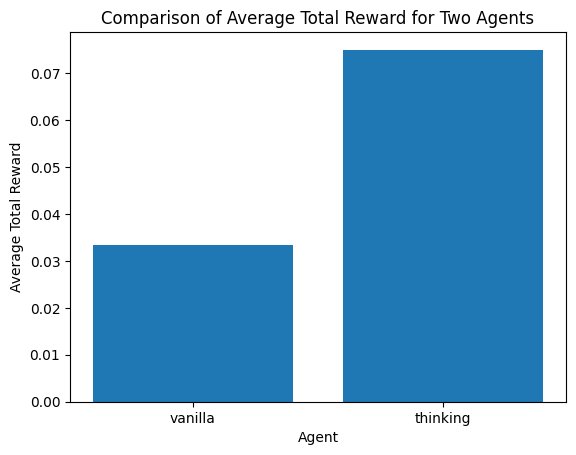

In [13]:
import numpy as np
import matplotlib.pyplot as plt

avg_rewards = {
    a: np.mean([ep["total_reward"] for ep in eps])
    for a, eps in episodes.items()
}

# make a bar chart
agents = list(avg_rewards.keys())
rewards = list(avg_rewards.values())

plt.bar(agents, rewards)
plt.xlabel("Agent")
plt.ylabel("Average Total Reward")
plt.title("Comparison of Average Total Reward for Two Agents")
plt.show()

# II. Supervised Fine-tuning (SFT) with Low-rank Adaptation (LORA)

In many problems, it is possible to collect demonstration data and learned an optimal strategy with supervision. For example, this could mean a human playing the game. In our case, text world comes with an engine to generate "gold paths" which help solve the task.

**Learning Plan**

* 📚 We will setup the LLM for efficient training using parameter efficient fine-tuning with LORA [(Hu et al., 2021)](https://arxiv.org/abs/2106.09685).
* 🥇 We will use the gold path engine to create a demonstration dataset
* 🏋️‍♀️ We will use the demonstration dataset for SFT
* 📈 We will evaluate the improved LLM

### 2.1 A primer on SFT and LORA

🕸️ LLMs are just neural networks. In particular, LLMs use the `transformer` architecture introduced in the paper *Attention Is All You Need*  [(Vaswani et al., 2017)](https://arxiv.org/abs/1706.03762). There is a good reason why this paper has over 100k citations ❗️


<figure>
<img src="https://drive.google.com/uc?export=view&id=1isVB0kvxCiE4Mz6eWaDaUu1QDI5BvZNC" alt="drawing" width="600"/>
<figcaption>
<b>Fig.</b> Schemetic representation of the Transformer Architecture and next-token prediction task.<br><em>Original image and blogpost</em>: <a href='https://medium.com/@akash.kesrwani99/understanding-next-token-prediction-concept-to-code-1st-part-7054dabda347'>Understanding Next Token Prediction: Concept To Code: 1st part!</a>
</figcaption>
</figure>


* 🔧 **Fine-tuning** 🔧
  * Fine tuning means updating the weights (parameters) of the neural network using a smaller dataset (aka downstream task).
  * In the context of LLM agents, we may also call this step *grounding* to the task.
  * Finetuning is typically done for far fewer optimization steps than the original training, and usually with smaller learning rates.
  * Finetuning is almost always better than training a model from scratch on the new ata.

* 🎻 **Classic approach** 🎻
  * *Last-layer tuning*: Retraining only the last layer of neural network.
  * *Full finetuning*: Update all weights of the network.
In regular neural network, it is common to update *all* the weights of neural network during finetuning.

#### 🦜 **LORA** 🦜
  * LORA takes the best of both finetuning regimes. Few parameters to train, but performs much better than last-layer tuning because it improves the entire neural network.
  * LORA or its many variations have become the standard to finetune LLMs [(Mao et al., 2024)](https://arxiv.org/abs/2407.11046)
  * The main idea is train an *low-rank adapter* as follows, which, for every parameter of the neural network, adds a new weight with fewer free parameters using the magic of low-rank matrix product factorization. The idea is illustrated below.
* 😱 **Worry not!** 😱
  * LORA is easily used without understanding its detailed inner workings.


<figure>
<img src="https://drive.google.com/uc?export=view&id=1HHeFZPdrVQWvA1EbWTHtyAuw_YNJjc-B" alt="drawing" width="800"/>
<figcaption>
<b>Fig.</b> Illustration of LORA.<br><em>Original image</em>: <a href='https://huggingface.co/docs/peft/main/en/developer_guides/lora'>HuggingFace PEFT docs</a>
</figcaption>
</figure>

#### 🏋🏽‍♂️ SFT is still next-token prediction** 🏋🏽‍♂️


In LLMs, the next-token prediction is trained using the **Cross-entropy Loss**, which measures how well the model's predicted probability distribution aligns with the true next token. SFT still uses this loss.

$$
\mathcal{L} = - \frac{1}{N} \sum_{i=1}^{N} \log \hat{P}_{\theta}(x_i | x_{<i})
$$

where:
- $N$ is the number of tokens in the sequence,
- $\hat{P}_{\theta}(x_i | x_{<i})$ represents the **predicted probability** of the correct token $x_i$ given the previous tokens,
- $x_{<i}$ represents the **context** (all previous tokens up to position $i$).

Since modern LLMs output **logits** (unnormalized scores for each token in the vocabulary), the probability $\hat{P}_{\theta}(x_i | x_{<i})$ is obtained by applying a **softmax**:

$$
\hat{P}_{\theta}(x_i | x_{<i}) = \frac{\exp(\text{logit}_{i, x_i})}{\sum_{j=1}^{V} \exp(\text{logit}_{i, j})}
$$

where:
- $\text{logit}_{i, x_i}$ is the model's predicted score for the correct next token $x_i$ at position $i$,
- $V$ is the vocabulary size,
- The denominator sums over all token scores to normalize them.


🐍 Cross-entropy in Pytorch 🐍

The cross-entropy is computed using `torch.nn.functional.cross_entropy`, which **directly takes raw logits** (not softmaxed) and target indices:

```python
# Example logits from a model (batch_size=1, seq_len=5, vocab_size=10)
logits = torch.tensor([
    [  # Sequence of 5 tokens (seq_len=5), each with vocab_size=10 logits
        [2.0, 1.0, 0.1, 3.2, 0.5, 2.3, 1.1, 0.2, 0.4, 1.7],  # Token 1
        [1.1, 2.5, 0.3, 2.8, 1.6, 1.7, 0.5, 0.7, 0.9, 1.3],  # Token 2
        [0.9, 1.4, 3.1, 1.5, 1.3, 0.8, 2.1, 1.9, 2.4, 0.7],  # Token 3
        [2.2, 0.5, 1.7, 1.8, 0.3, 2.6, 1.2, 1.5, 1.9, 0.6],  # Token 4
        [1.7, 2.2, 1.0, 1.4, 2.3, 0.9, 1.5, 1.6, 2.1, 1.8]   # Token 5
    ]
])  # Shape: (batch_size=1, seq_len=5, vocab_size=10)

# Target tokens (ground truth indices), same shape as seq_len
targets = torch.tensor([[3, 1, 2, 5, 4]])  # Shape: (batch_size=1, seq_len)

# Compute cross-entropy loss directly
loss = torch.nn.functional.cross_entropy(logits, targets)
```

### 2.2 Gather the Demonstration dataset

The strategy will be to mimic our previous episode_rollout busing the `env.getGoldActionSequence()` feature and execute that path.

In [ ]:
def expert_episode_rollout(
    gameFold: str = Literal["train", "valditation", "test"],
    env_factory_options: dict = {},
):
    # Initialize env
    env = env_factory(**env_factory_options)
    obs, infos = env.reset(gameFold=gameFold, generateGoldPath=True)
    gold_actions = env.getGoldActionSequence()

    # Initialize Memory
    memory = []
    memory.append("## Welcome to TextWorld")
    memory.append(f"`[Task]`: {env.getTaskDescription()}")
    memory.append(f"`[Starting Obs]`: {obs}")

    # Make initial plan
    # Print progress
    pbar = tqdm(desc="Episode Progress")

    # Collected prompt/action/reward triples for training
    collected_data = []

    # Start loop
    done = False
    total_reward = 0.0

    step = 0
    while not done:
        # Update task prompt
        memory.append(f"***`Action step {step}`**")
        memory.append(f"`[Time]` {datetime.now().strftime('%H:%M:%S')}")
        memory.append(f"`[Valid Actions]`: {infos['validActions']}")
        task_prompt = build_task_prompt(memory)

        # Execute gold path action
        action = gold_actions[step]

        # Advance the Environment
        obs, reward, done, infos = env.step(action)

        # Update memory
        memory.append(f"`[Action]`: {action}")
        memory.append(f"`[Reward]`: {reward:0.2f}")
        memory.append(f"`[Obs]`: {obs}")

        collected_data.append((task_prompt, "", action, reward))  # empty for the thoughts

        total_reward += reward
        step += 1
        pbar.update(1)

    return memory, collected_data, total_reward

In [ ]:
expert_episodes = {'expert': []}

num_episodes_per_agent = 20

for ep in range(num_episodes_per_agent):
    memory, data, total_reward = expert_episode_rollout(gameFold="train")
    expert_episodes['expert'].append({"ep": ep, "total_reward": total_reward, "memory": memory, "data": data})

mean_reward_expert = np.mean([ep["total_reward"] for ep in expert_episodes["expert"]])
print(f"Mean reward for expert: {mean_reward_expert}")

# Visualize expert episode
printmd('\n\n'.join(expert_episodes['expert'][0]['memory']))

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Mean reward for expert: 0.75625


## Welcome to TextWorld

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a vegetable oil. 
To the West you see the kitchen. 

***`Action step 0`**

`[Time]` 13:00:54

`[Valid Actions]`: ['take vegetable oil', 'move west', 'inventory', 'open wastepaper basket', 'look around']

`[Action]`: look around

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a vegetable oil. 
To the West you see the kitchen. 

***`Action step 1`**

`[Time]` 13:00:54

`[Valid Actions]`: ['open wastepaper basket', 'take vegetable oil', 'move west', 'inventory', 'look around']

`[Action]`: take vegetable oil

`[Reward]`: 0.12

`[Obs]`: You take the vegetable oil.

***`Action step 2`**

`[Time]` 13:00:54

`[Valid Actions]`: ['put vegetable oil in side table', 'put vegetable oil in coffee table', 'inventory', 'open wastepaper basket', 'put vegetable oil in arm chair', 'put vegetable oil in end table', 'look around', 'put vegetable oil in sofa', 'put vegetable oil in TV stand', 'put vegetable oil in book case', 'move west']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. There is also a cushion. You also see a picture. In another part of the room you see a wastepaper. 
To the North you see a closed frosted-glass door. To the East you see the living room. 

***`Action step 3`**

`[Time]` 13:00:54

`[Valid Actions]`: ['take cushion', 'open fridge', 'open dishwasher', 'open door to north', 'move east', 'open kitchen cupboard', 'put vegetable oil in counter', 'look around', 'take wastepaper', 'take picture', 'open trash can', 'open cutlery drawer', 'move north', 'inventory', 'close door to north', 'put vegetable oil in dining chair']

`[Action]`: take cushion

`[Reward]`: 0.12

`[Obs]`: You take the cushion.

***`Action step 4`**

`[Time]` 13:00:54

`[Valid Actions]`: ['take wastepaper', 'open cutlery drawer', 'put cushion in dining chair', 'take picture', 'inventory', 'open door to north', 'open trash can', 'put vegetable oil in counter', 'open kitchen cupboard', 'look around', 'put vegetable oil in dining chair', 'put cushion in counter', 'open fridge', 'move east', 'move north', 'open dishwasher', 'close door to north']

`[Action]`: take picture

`[Reward]`: 0.12

`[Obs]`: You take the picture.

***`Action step 5`**

`[Time]` 13:00:54

`[Valid Actions]`: ['open dishwasher', 'put picture in counter', 'close door to north', 'move north', 'put cushion in dining chair', 'put vegetable oil in dining chair', 'look around', 'inventory', 'move east', 'open kitchen cupboard', 'open trash can', 'open door to north', 'put cushion in counter', 'put vegetable oil in counter', 'take wastepaper', 'put picture in dining chair', 'open cutlery drawer', 'open fridge']

`[Action]`: take wastepaper

`[Reward]`: 0.12

`[Obs]`: You take the wastepaper.

***`Action step 6`**

`[Time]` 13:00:54

`[Valid Actions]`: ['move east', 'put picture in dining chair', 'open fridge', 'put cushion in dining chair', 'move north', 'open kitchen cupboard', 'open trash can', 'put vegetable oil in dining chair', 'open dishwasher', 'put cushion in counter', 'close door to north', 'put vegetable oil in counter', 'put picture in counter', 'look around', 'put wastepaper in counter', 'open door to north', 'put wastepaper in dining chair', 'open cutlery drawer', 'inventory']

`[Action]`: open kitchen cupboard

`[Reward]`: 0.00

`[Obs]`: You open the kitchen cupboard. It's empty inside.

***`Action step 7`**

`[Time]` 13:00:54

`[Valid Actions]`: ['open trash can', 'put vegetable oil in counter', 'open cutlery drawer', 'put wastepaper in kitchen cupboard', 'open door to north', 'put cushion in counter', 'put picture in kitchen cupboard', 'close door to north', 'look around', 'put vegetable oil in dining chair', 'open dishwasher', 'put picture in counter', 'put vegetable oil in kitchen cupboard', 'put wastepaper in dining chair', 'put picture in dining chair', 'inventory', 'move north', 'close kitchen cupboard', 'put cushion in kitchen cupboard', 'move east', 'put cushion in dining chair', 'open fridge', 'put wastepaper in counter']

`[Action]`: put vegetable oil in kitchen cupboard

`[Reward]`: 0.12

`[Obs]`: You put the vegetable oil in the kitchen cupboard.

***`Action step 8`**

`[Time]` 13:00:54

`[Valid Actions]`: ['put cushion in dining chair', 'put wastepaper in counter', 'close kitchen cupboard', 'take vegetable oil', 'put wastepaper in dining chair', 'move north', 'put picture in counter', 'put cushion in counter', 'open trash can', 'open dishwasher', 'move east', 'inventory', 'open cutlery drawer', 'close door to north', 'put wastepaper in kitchen cupboard', 'look around', 'put picture in kitchen cupboard', 'put cushion in kitchen cupboard', 'open door to north', 'put picture in dining chair', 'open fridge']

`[Action]`: open trash can

`[Reward]`: 0.00

`[Obs]`: You open the trash can. It's empty inside.

***`Action step 9`**

`[Time]` 13:00:54

`[Valid Actions]`: ['close door to north', 'open door to north', 'put cushion in dining chair', 'open fridge', 'move east', 'inventory', 'put cushion in counter', 'look around', 'open dishwasher', 'close kitchen cupboard', 'put wastepaper in counter', 'put wastepaper in dining chair', 'put picture in kitchen cupboard', 'put cushion in kitchen cupboard', 'close trash can', 'put picture in dining chair', 'put cushion in trash can', 'open cutlery drawer', 'put wastepaper in kitchen cupboard', 'take vegetable oil', 'put picture in trash can', 'put wastepaper in trash can', 'move north', 'put picture in counter']

`[Action]`: put wastepaper in trash can

`[Reward]`: 0.12

`[Obs]`: You put the wastepaper in the trash can.

***`Action step 10`**

`[Time]` 13:00:54

`[Valid Actions]`: ['move north', 'put cushion in kitchen cupboard', 'put cushion in counter', 'close kitchen cupboard', 'close trash can', 'open cutlery drawer', 'open door to north', 'put picture in trash can', 'look around', 'put picture in dining chair', 'put cushion in dining chair', 'take vegetable oil', 'inventory', 'put cushion in trash can', 'move east', 'put picture in kitchen cupboard', 'take wastepaper', 'put picture in counter', 'open dishwasher', 'open fridge', 'close door to north']

`[Action]`: open door to north

`[Reward]`: 0.00

`[Obs]`: You open the frosted-glass door, revealing the pantry. 

***`Action step 11`**

`[Time]` 13:00:54

`[Valid Actions]`: ['put cushion in trash can', 'inventory', 'close door to north', 'open cutlery drawer', 'move east', 'put picture in counter', 'close trash can', 'move north', 'put picture in dining chair', 'close kitchen cupboard', 'open dishwasher', 'open fridge', 'put cushion in kitchen cupboard', 'put cushion in dining chair', 'put picture in trash can', 'look around', 'take wastepaper', 'take vegetable oil', 'open door to north', 'put picture in kitchen cupboard', 'put cushion in counter']

`[Action]`: move north

`[Reward]`: 0.00

`[Obs]`: You are in the pantry. In one part of the room you see a folding chair, that has nothing on it. There is also a shelf, that has nothing on it. 
Through an open frosted-glass door, to the South you see the kitchen. 

***`Action step 12`**

`[Time]` 13:00:54

`[Valid Actions]`: ['put picture in folding chair', 'open door to south', 'move south', 'close door to south', 'put cushion in shelf', 'put picture in shelf', 'put cushion in folding chair', 'look around', 'inventory']

`[Action]`: move south

`[Reward]`: 0.00

`[Obs]`: You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see An open kitchen cupboard, that contains a vegetable oil. There is also a cutlery drawer that is closed. You also see An open trash can, that contains a wastepaper. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. 
Through an open frosted-glass door, to the North you see the pantry. To the East you see the living room. 

With this explanation in mind, let us start with collecting the expert data into a more usable format.

In [ ]:
# 1. Combine all the data
data_list = []
for ep in expert_episodes["expert"]:
    for prompt, _, action, _ in ep["data"]:
        data_list.append({"prompt": prompt, "action": action})
data_list[0]

{'prompt': "## Welcome to TextWorld\n\n`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.\n\n`[Starting Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a vegetable oil. \nTo the West you see the kitchen. \n\n***`Action step 0`**\n\n`[Time]` 13:00:54\n\n`[Valid Actions]`: ['take vegetable oil', 'move west', 'inventory', 'open wastepaper basket', 'look around']Answer the questions below. Give all answers using plain text or bullet points. Don'

### 2.3 Training / Fine-tuning


We now use the `peft` library to setup LORA. Incredibly, only 0.03% of the weights will need to be updated.

In [ ]:
from peft import LoraConfig, TaskType

# LORA config
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=4,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none"
)

# Wrap the original model. The wrapped model has fewer trainable paramters
model_lora = peft.get_peft_model(model, peft_config)
model_lora.print_trainable_parameters()

display(model_lora)

trainable params: 425,984 || all params: 1,236,240,384 || trainable%: 0.0345


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=4, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=4, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linear(in_fea

Next, let's break down an example of how we compute the loss with one of the entries of our collected data.

ℹ️ Pay attention to the tokenizations scheme. It's easy to miss! We need to make sure the prompt is transformed to the chat template used by the LLM ℹ️

In [ ]:
prompt, action = data_list[0]["prompt"], data_list[0]["action"]

# we need to obtain the full prompt first
action_prompt = prompt + (
    "\n\nNow, choose exactly one valid action from the list and no additional information.\n"
      f"The valid actions are: {','.join(valid_actions)}\n"
)
messages = {"role": "user", "content": action_prompt}
full_prompt = tokenizer.apply_chat_template([messages], tokenize=False, add_generation_prompt=True)

action_with_eot = action + "<|eot_id|><|start_header_id|>assistant<|end_header_id|>" # !!!!
tokenized_prompt = tokenizer(full_prompt, return_tensors="pt").input_ids.to("cuda")[0]
tokenized_action = tokenizer(action_with_eot, return_tensors="pt").input_ids.to("cuda")[0]

print(f"> Prompt: {full_prompt}\n")
print(f"> Tokenized Prompt: {tokenized_prompt}\n")
print(f"> Action: {action_with_eot}\n")
print(f"> Tokenized Action: {tokenized_action}\n")

# concatenate prompt/action that will be the input to the language model for next
# token prediction. We don't need to include the last token of the action, since
# it is only used as a label for the next token prediction later.
device = "cuda" if torch.cuda.is_available() else "cpu"
input_ids = torch.cat([tokenized_prompt, tokenized_action[:-1]]).to(device)

# eval LLM - we need the extra dimension since the model expects a batch
# this is achieved by unsqueeze(0)
outputs = model_lora(input_ids.unsqueeze(0))
print(f"> Model outputs: {outputs}")

# Now we will compute the next token prediction loss, but only on the last tokens
# for the action.
# The loss is the cross entropy with the logits and the true next tokens (i.e., the action tokens)
num_action_tokens = len(tokenized_action)
next_token_logits = outputs.logits[0, -num_action_tokens:]
loss = torch.nn.functional.cross_entropy(next_token_logits, tokenized_action)
print(f"> Cross entropy loss Loss: {loss:.2f}")

# clean up
del outputs, loss, next_token_logits
torch.cuda.empty_cache()

> Prompt: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 07 Mar 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

## Welcome to TextWorld

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a vegetable oil. 
To the West you see the kitchen. 

***`Action step 0`**

`[Time]` 13:00:54

`[Valid Actions]`: ['take veg


🏋️‍♀️ **We are ready to train**🏋️‍♀️ All that is left is to compute the loss and call the optimizer ineach step.

𝝯 **Gradient accumulation** 𝝯 We did not implement batches, which is typically used to improve training. But we can use a very simple trick called gradient accumulation. This trick is handy particularly with larger models when batched training does not fit in memory.


In [ ]:
import accelerate
import peft


def train(model, tokenizer, data_list, epochs=20):
    """
    Train function that ensures memory is freed after training.

    Args:
        model (torch.nn.Module): The model to be trained.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for processing text inputs.
        data_list (list): The dataset containing prompts and actions.
        epochs (int, optional): Number of epochs. Defaults to 20.
    """
    # Set model in train mode (e.g., dropout on)
    model.train()

    # standard choice of optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=2e-5,
        betas=(0.9, 0.95),
        eps=1e-8,
        weight_decay=0.01,
    )

    # accelerator for the gradient accumulation and device management
    accelerator = accelerate.Accelerator(gradient_accumulation_steps=4)
    model, optimizer = accelerator.prepare(model, optimizer)
    device = accelerator.device

    all_losses = []

    # training loop
    for epoch in range(epochs):
        epoch_losses = []

        # random order of data
        indices = np.random.permutation(len(data_list))

        for i in tqdm(range(len(data_list))):
            data = data_list[indices[i]]
            action = data["action"]
            task_prompt = data["prompt"]

            # Make full prompt
            action_prompt = task_prompt + (
                "\n\nNow, choose exactly one valid action from the list and no additional information.\n"
                f"The valid actions are: {','.join(valid_actions)}\n"
            )
            messages = {"role": "user", "content": action_prompt}
            full_prompt = tokenizer.apply_chat_template([messages], tokenize=False, add_generation_prompt=True)

            # Tokenize inputs and move to device
            prompt_tokens = tokenizer(full_prompt, return_tensors="pt").input_ids.to(device)[0]
            action_with_eot = action + "<|eot_id|><|start_header_id|>assistant<|end_header_id|>" # !!!! Easy to miss
            action_tokens = tokenizer(action_with_eot, return_tensors="pt").input_ids.to(device)[0]
            input_ids = torch.cat([prompt_tokens, action_tokens[:-1]])

            # Compute loss with gradient accumulation
            with accelerator.accumulate(model):
                outputs = model(input_ids.unsqueeze(0))
                num_action_tokens = len(action_tokens)
                next_token_logits = outputs.logits[0, -num_action_tokens:]
                loss = torch.nn.functional.cross_entropy(next_token_logits, action_tokens)

            optimizer.zero_grad()
            accelerator.backward(loss)
            optimizer.step()
            epoch_losses.append(loss.item())

            # free CUDA memory at every step
            torch.cuda.empty_cache()

        print(f"Epoch {epoch+1} | Loss: {np.mean(epoch_losses):.2f}")
        all_losses.extend(epoch_losses)

    # Set model back to eval
    model.eval()

    return all_losses

## Uncomment when training
# Start training
# all_losses = train(model_lora, tokenizer, data_list, epochs=5)
# model_lora.save_pretrained(f"{target_dir}/sft_lora")
# with open(f"{target_dir}/sft_losses.json", "w") as f:
#     json.dump(all_losses, f)

## Comment when training
## Load from pretrained weights on github
# Combine LORA adapter with the original LLM weights
model_lora = peft.PeftModel.from_pretrained(model, f"hdsi-winter-workshop/checkpoints/sft_lora/")
all_losses = json.load(open(f"hdsi-winter-workshop/checkpoints/sft_losses.json", "r"))

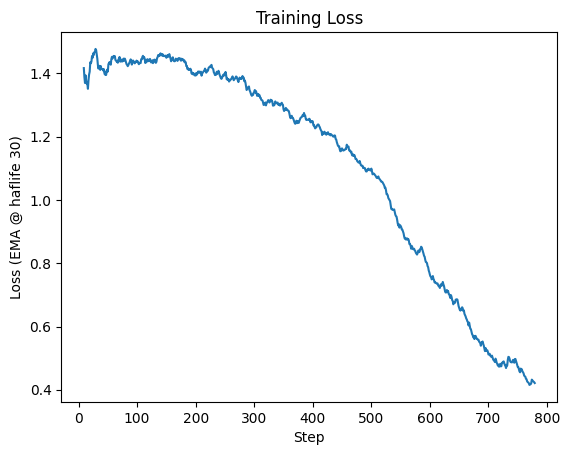

In [ ]:
# @title SFT loss
import pandas as pd
import matplotlib.pyplot as plt
pd.Series(all_losses).ewm(halflife=30, min_periods=10).mean().plot()
plt.xlabel("Step")
plt.ylabel("Loss (EMA @ haflife 30)")
plt.title("Training Loss")
plt.show()


### 2.4 Evaluate SFT policy

In [ ]:
## Run eval loop with fine-tuned model
sft_episodes = {"sft": []}
num_episodes_per_agent = 30

for ep in range(num_episodes_per_agent):
    printmd(f"#### Episode {ep}")
    memory, data, total_reward = episode_rollout(model_lora, gameFold="test", thinking=False, seed=ep * 123)
    sft_episodes['sft'].append({"ep": ep, "total_reward": total_reward, "memory": memory, "data": data})

## save results
with open(f"{target_dir}/episodes_sft_agent.json", "w") as f:
    json.dump(sft_episodes, f)

## print an episode
printmd('\n\n'.join(sft_episodes['sft'][0]['memory']))

#### Episode 0

Episode Progress: 0it [00:00, ?it/s]

#### Episode 1

Episode Progress: 0it [00:00, ?it/s]

#### Episode 2

Episode Progress: 0it [00:00, ?it/s]

#### Episode 3

Episode Progress: 0it [00:00, ?it/s]

#### Episode 4

Episode Progress: 0it [00:00, ?it/s]

#### Episode 5

Episode Progress: 0it [00:00, ?it/s]

#### Episode 6

Episode Progress: 0it [00:00, ?it/s]

#### Episode 7

Episode Progress: 0it [00:00, ?it/s]

#### Episode 8

Episode Progress: 0it [00:00, ?it/s]

#### Episode 9

Episode Progress: 0it [00:00, ?it/s]

#### Episode 10

Episode Progress: 0it [00:00, ?it/s]

#### Episode 11

Episode Progress: 0it [00:00, ?it/s]

#### Episode 12

Episode Progress: 0it [00:00, ?it/s]

#### Episode 13

Episode Progress: 0it [00:00, ?it/s]

#### Episode 14

Episode Progress: 0it [00:00, ?it/s]

#### Episode 15

Episode Progress: 0it [00:00, ?it/s]

#### Episode 16

Episode Progress: 0it [00:00, ?it/s]

#### Episode 17

Episode Progress: 0it [00:00, ?it/s]

#### Episode 18

Episode Progress: 0it [00:00, ?it/s]

#### Episode 19

Episode Progress: 0it [00:00, ?it/s]

#### Episode 20

Episode Progress: 0it [00:00, ?it/s]

#### Episode 21

Episode Progress: 0it [00:00, ?it/s]

#### Episode 22

Episode Progress: 0it [00:00, ?it/s]

#### Episode 23

Episode Progress: 0it [00:00, ?it/s]

#### Episode 24

Episode Progress: 0it [00:00, ?it/s]

#### Episode 25

Episode Progress: 0it [00:00, ?it/s]

#### Episode 26

Episode Progress: 0it [00:00, ?it/s]

#### Episode 27

Episode Progress: 0it [00:00, ?it/s]

#### Episode 28

Episode Progress: 0it [00:00, ?it/s]

#### Episode 29

Episode Progress: 0it [00:00, ?it/s]

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. There is also a newspaper. You also see a dirty mesh skimmer. 
To the West you see the living room. 

###  `Action step 1`

`[Time]` 13:01:04

`[Valid Actions]`: ['open kitchen cupboard', 'take newspaper', 'take dirty mesh skimmer', 'open trash can', 'open fridge', 'open cutlery drawer', 'move west', 'inventory', 'open dishwasher', 'look around']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a can opener. There is also a milk. 
To the East you see the kitchen. To the West you see a closed wood door. 

###  `Action step 2`

`[Time]` 13:01:04

`[Valid Actions]`: ['look around', 'inventory', 'open door to west', 'move west', 'open wastepaper basket', 'close door to west', 'take can opener', 'take milk', 'move east']

`[Action]`: move east

`[Reward]`: 0.00

`[Obs]`: You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. There is also a newspaper. You also see a dirty mesh skimmer. 
To the West you see the living room. 

###  `Action step 3`

`[Time]` 13:01:04

`[Valid Actions]`: ['take newspaper', 'open fridge', 'move west', 'open trash can', 'open kitchen cupboard', 'look around', 'open dishwasher', 'inventory', 'take dirty mesh skimmer', 'open cutlery drawer']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a can opener. There is also a milk. 
To the East you see the kitchen. To the West you see a closed wood door. 

###  `Action step 4`

`[Time]` 13:01:04

`[Valid Actions]`: ['inventory', 'open door to west', 'move west', 'take milk', 'take can opener', 'close door to west', 'move east', 'look around', 'open wastepaper basket']

`[Action]`: open door to west

`[Reward]`: 0.00

`[Obs]`: You open the wood door, revealing the bedroom. 

###  `Action step 5`

`[Time]` 13:01:04

`[Valid Actions]`: ['look around', 'inventory', 'take can opener', 'open door to west', 'open wastepaper basket', 'take milk', 'move west', 'move east', 'close door to west']

`[Action]`: look around

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a can opener. There is also a milk. 
To the East you see the kitchen. Through an open wood door, to the West you see the bedroom. 

###  `Action step 6`

`[Time]` 13:01:05

`[Valid Actions]`: ['close door to west', 'look around', 'inventory', 'move east', 'open door to west', 'move west', 'take can opener', 'open wastepaper basket', 'take milk']

`[Action]`: take milk

`[Reward]`: 0.12

`[Obs]`: You take the milk.

###  `Action step 7`

`[Time]` 13:01:05

`[Valid Actions]`: ['put milk in coffee table', 'put milk in book case', 'move west', 'put milk in arm chair', 'put milk in TV stand', 'inventory', 'move east', 'put milk in sofa', 'take can opener', 'put milk in side table', 'close door to west', 'open wastepaper basket', 'look around', 'put milk in end table', 'open door to west']

`[Action]`: take can opener

`[Reward]`: 0.12

`[Obs]`: You take the can opener.

###  `Action step 8`

`[Time]` 13:01:05

`[Valid Actions]`: ['move west', 'put can opener in arm chair', 'open wastepaper basket', 'put can opener in book case', 'move east', 'put milk in book case', 'put milk in arm chair', 'put can opener in sofa', 'put milk in side table', 'put milk in sofa', 'close door to west', 'put milk in coffee table', 'put can opener in TV stand', 'look around', 'put can opener in end table', 'open door to west', 'put can opener in coffee table', 'put milk in TV stand', 'inventory', 'put can opener in side table', 'put milk in end table']

`[Action]`: move east

`[Reward]`: 0.00

`[Obs]`: You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. There is also a newspaper. You also see a dirty mesh skimmer. 
To the West you see the living room. 

###  `Action step 9`

`[Time]` 13:01:06

`[Valid Actions]`: ['put can opener in dining chair', 'open fridge', 'take dirty mesh skimmer', 'move west', 'put can opener in counter', 'put milk in counter', 'take newspaper', 'open trash can', 'open dishwasher', 'put milk in dining chair', 'look around', 'inventory', 'open kitchen cupboard', 'open cutlery drawer']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. 
To the East you see the kitchen. Through an open wood door, to the West you see the bedroom. 

###  `Action step 10`

`[Time]` 13:01:06

`[Valid Actions]`: ['look around', 'put can opener in side table', 'put can opener in end table', 'put milk in coffee table', 'inventory', 'put milk in book case', 'put milk in arm chair', 'open wastepaper basket', 'put milk in side table', 'put can opener in book case', 'open door to west', 'put can opener in sofa', 'put can opener in TV stand', 'put milk in sofa', 'put can opener in arm chair', 'put milk in end table', 'put milk in TV stand', 'put can opener in coffee table', 'move east', 'close door to west', 'move west']

`[Action]`: move east

`[Reward]`: 0.00

`[Obs]`: You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. There is also a newspaper. You also see a dirty mesh skimmer. 
To the West you see the living room. 

###  `Action step 11`

`[Time]` 13:01:06

`[Valid Actions]`: ['put milk in dining chair', 'open trash can', 'put can opener in dining chair', 'take newspaper', 'put can opener in counter', 'move west', 'put milk in counter', 'open dishwasher', 'open cutlery drawer', 'open kitchen cupboard', 'look around', 'open fridge', 'take dirty mesh skimmer', 'inventory']

`[Action]`: inventory

`[Reward]`: 0.00

`[Obs]`: Inventory: 
  a milk
  a can opener


###  `Action step 12`

`[Time]` 13:01:07

`[Valid Actions]`: ['open trash can', 'look around', 'put can opener in counter', 'put milk in dining chair', 'open cutlery drawer', 'put milk in counter', 'open fridge', 'open dishwasher', 'open kitchen cupboard', 'inventory', 'take newspaper', 'take dirty mesh skimmer', 'put can opener in dining chair', 'move west']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. 
To the East you see the kitchen. Through an open wood door, to the West you see the bedroom. 

###  `Action step 13`

`[Time]` 13:01:07

`[Valid Actions]`: ['put can opener in sofa', 'move west', 'put can opener in TV stand', 'put milk in arm chair', 'put milk in side table', 'put can opener in arm chair', 'inventory', 'put milk in end table', 'put milk in sofa', 'put milk in TV stand', 'put can opener in end table', 'close door to west', 'open door to west', 'open wastepaper basket', 'put milk in coffee table', 'put milk in book case', 'move east', 'look around', 'put can opener in coffee table', 'put can opener in side table', 'put can opener in book case']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You are in the bedroom. In one part of the room you see a dressing table, that has nothing on it. There is also a desk chair, that has nothing on it. You also see a desk, that has nothing on it. In another part of the room you see a chest of drawers that is closed. In one part of the room you see a wardrobe that is closed. There is also a night stand, that has nothing on it. You also see a bed, that has nothing on it. 
Through an open wood door, to the East you see the living room. 

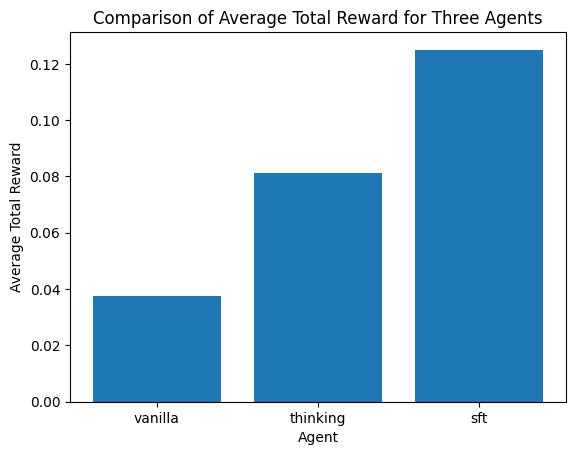

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

all_eps = baseline_episodes | sft_episodes

avg_rewards = {
    a: np.mean([ep["total_reward"] for ep in all_eps[a]])
    for a in ["vanilla", "thinking", "sft"]
}

# make a bar chart
agents = list(avg_rewards.keys())
rewards = list(avg_rewards.values())

plt.bar(agents, rewards)
plt.xlabel("Agent")
plt.ylabel("Average Total Reward")
plt.title("Comparison of Average Total Reward for Three Agents")
plt.show()

# III. Reinforcement Learning


* 🥅 **Limitations of SFT** 🥅 Supervised fine-tuning refines LLMs using static datasets, there are some problems:
    * ❌ The SDR objective may be misaligned with the true objective of optimizing reward over time. This small mismatch can reduce overall peformance.
    * 🤔 In fact, SFT has been studied under the name *Behavioral Cloning* in the RL literature, showing the distribution shift between the expert and the learning agent can create several problems [(Zare et al., 2023)](https://arxiv.org/abs/2309.02473)..


 * 🐕 **Reinforcement Learning** 🐕
  * 🦾 RL addresses the limitations in SFT by enabling models to learn optimal behaviors through trial and error within interactive settings using a reward signal as feedback. In our case, we will employ RL to train LLMs using the TextWorld reward.
  * 😓 RL is very hard to train! Here we will make several simplifications to het a small feel of the approach.


* 📚 **Learning Plan**📚
  1. Let's start with an overview of RL of MDPs.
  2. Let's explain the policy gradients approach. We will use a super simplified version of proximal policy optimization [(Schulman et al. 2017)](https://arxiv.org/abs/1707.06347).
  3. We will implement a training loop and use it to further refine our SFT agent.



<figure>
<img src="https://drive.google.com/uc?export=view&id=1v3eVKBfTXUymQOg1ID4ha-l9bMYCtha0" alt="drawing" width="800"/>
<figcaption>
<b>Fig.</b> Turing award winners.<br><em>Original article</em>: <a href='https://www.nytimes.com/welcome-subscriber/interest-selection?EXIT_URI=https%3A%2F%2Fwww.nytimes.com%2F2025%2F03%2F05%2Ftechnology%2Fturing-award-andrew-barto-richard-sutton.html'>Turing Award Goes to 2 Pioneers of Artificial Intelligence</a>
</figcaption>
</figure> -->



## 3.1 A Primer on RL



### 🎯 RL and MDPs

RL trains an agent through **interaction** 🕹️ with an environment, aiming to **maximize cumulative rewards** 💰. Unlike supervised learning (labels) or unsupervised learning (patterns), RL relies solely on **trial-and-error feedback**.

**Key components** of an RL setup:
- **Agent** 🤖 chooses actions.
- **Environment** 🌎 provides feedback (state & reward).
- **Reward** 🏅 signals how good the action was.

The RL problem is formalized using **Markov Decision Processes (MDPs)**:
- **State** $s_t$ 📍: Current situation.
- **Action** $a_t$ 🎮: Decision taken by the agent.
- **Reward** $r_t$ 🏅: Immediate feedback from the environment.

The goal 🏆:
$$
\text{Maximize expected return } J = \mathbb{E}\left[\sum_{t=0}^{H-1} r_t\right].
$$

### ∇∇ Policy Gradients

Policy gradients directly optimize the probability of choosing action $a$ in state $s$, aka, the policy $\pi_\theta(a|s)$, to maximize cumulative rewards. Instead of learning values, we adjust policy parameters $\theta$ via **gradient ascent** 📈.

The policy gradient theorem says:
$$
\nabla_{\theta} J(\theta) = \mathbb{E}\left[ \nabla_{\theta} \log \pi_{\theta}(a|s) \cdot G_t \right]
$$
where $G_t = \sum_{h=t}^{H-1} r_t$ is the **return**: the cumulative reward from the current time $t$ until the end of the episode.

In plain English 📚:
> "Increase the likelihood of actions that yield higher returns and decrease for lower returns."
<!--
**Proximal Policy Optimization (PPO)** 📌:
- PPO stabilizes training by limiting policy changes.
- Uses a clipped objective to prevent drastic policy updates:
$$
L^{\text{PPO}}(\theta) = \mathbb{E}\left[ \min(r_t(\theta)G_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)G_t) \right]
$$

where $r_t(\theta) = \frac{\pi_{\theta}(a|s)}{\pi_{\theta_{\text{old}}}(a|s)}$.

PPO's simple mantra 🧘:
> "Improve gently, avoid radical changes."

That's it! Now we're ready to fine-tune the LLM with RL using policy gradients! 🌟 -->


### 💰 How to Assign Token-level Rewards in RL for LLMs

To fine-tune an LLM using Reinforcement Learning, we must assign rewards at the token level. But how do we do this if our environment only provides a reward at the end of a full response?

Here's the trick ✨: we simply treat the final reward as the **return** (total reward) and assign it equally to all tokens generated in that sequence. In simple terms 🗣️:  
> *"If your final response is rewarded, every token that helped create that response shares the credit equally!"*

Now you're ready to apply RL to fine-tune your LLMs at the token level! 🚀

## PPO w/GAE

In [16]:
# Lighter LoRA config for lower memory usage
peft_config = peft.LoraConfig(
    r=32,                          # Smaller rank
    lora_alpha=32,
    target_modules=[
        "q_proj", "v_proj",        # Only query and value (fewer modules)
    ],
    lora_dropout=0.05,
    bias="none",
    task_type=peft.TaskType.CAUSAL_LM,
)

In [17]:
# ============================================================================
# IMPROVED RL TRAINING WITH GAE (Generalized Advantage Estimation)
# Based on RAGEN's StarPO-S framework
# ============================================================================

import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import peft
import accelerate

# ----------------------------------------------------------------------------
# 1. VALUE HEAD (CRITIC)
# ----------------------------------------------------------------------------

# ============================================================================
# FIX: Update the ValueHead class to match model dtype
# ============================================================================

class ValueHead(nn.Module):
    """Critic network for estimating state values"""
    def __init__(self, hidden_size, dtype=torch.float16):  # Add dtype parameter
        super().__init__()
        self.value_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2, dtype=dtype),  # Match dtype
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1, dtype=dtype)  # Match dtype
        )

    def forward(self, hidden_states):
        """
        Args:
            hidden_states: [batch, seq_len, hidden_size]
        Returns:
            value: [batch] - scalar value estimate
        """
        # Take last token's hidden state
        last_hidden = hidden_states[:, -1, :]
        return self.value_head(last_hidden).squeeze(-1)


# ----------------------------------------------------------------------------
# 2. ROLLOUT WITH VALUE ESTIMATION
# ----------------------------------------------------------------------------

def rollout_step_for_rl_with_gae(model, critic, tokenizer, num_episodes=1, gamma=0.99):
    """
    Rollout and collect trajectories with value estimates.

    Args:
        model: The policy model
        critic: Value function (critic)
        tokenizer: Tokenizer
        num_episodes: Number of episodes to collect
        gamma: Discount factor

    Returns:
        List of trajectory data with rewards and values
    """
    model.eval()
    critic.eval()
    device = next(model.parameters()).device
    data_list = []

    for _ in range(num_episodes):
        _, episode_data, _ = episode_rollout(model, gameFold="train", thinking=False)

        # Process episode in forward order
        processed_episode_data = []
        for (prompt, _, action, _, reward) in episode_data:
            # Tokenize
            messages = {"role": "user", "content": prompt}
            full_prompt = tokenizer.apply_chat_template([messages], tokenize=False, add_generation_prompt=True)
            action_with_eot = action + "<|eot_id|><|start_header_id|>assistant<|end_header_id|>"
            tokenized_prompt = tokenizer(full_prompt, return_tensors="pt").input_ids[0]
            tokenized_action = tokenizer(action_with_eot, return_tensors="pt").input_ids[0]
            input_ids = torch.cat([tokenized_prompt, tokenized_action])

            # Estimate value using critic
            with torch.no_grad():
                outputs = model(input_ids.unsqueeze(0).to(device), output_hidden_states=True)
                hidden_states = outputs.hidden_states[-1]
                value = critic(hidden_states).item()

            processed_episode_data.append({
                "input_ids": input_ids,
                "tokenized_action": tokenized_action,
                "reward": reward,
                "value": value,
            })

        data_list.extend(processed_episode_data)

    return data_list


# ----------------------------------------------------------------------------
# 3. COMPUTE GAE (Generalized Advantage Estimation)
# ----------------------------------------------------------------------------

def compute_gae(data_list, gamma=0.99, gae_lambda=0.95):
    """
    Compute Generalized Advantage Estimation.

    GAE balances bias-variance tradeoff:
    - lambda=0: Pure TD (low variance, high bias)
    - lambda=1: Pure Monte Carlo (high variance, low bias)

    Args:
        data_list: List of trajectory steps with 'reward' and 'value'
        gamma: Discount factor
        gae_lambda: GAE lambda parameter

    Returns:
        data_list with 'advantage' and 'return' added
    """
    advantages = []
    returns = []

    # Last value is 0 (terminal state)
    next_value = 0
    gae = 0

    # Process in reverse (from end to start)
    for data in reversed(data_list):
        reward = data["reward"]
        value = data["value"]

        # TD error: δ_t = r_t + γ*V(s_{t+1}) - V(s_t)
        delta = reward + gamma * next_value - value

        # GAE: A_t = δ_t + (γλ)*δ_{t+1} + (γλ)^2*δ_{t+2} + ...
        gae = delta + gamma * gae_lambda * gae

        # Return: R_t = A_t + V(s_t)
        return_value = gae + value

        advantages.insert(0, gae)
        returns.insert(0, return_value)

        next_value = value

    # Add to data_list
    for i, data in enumerate(data_list):
        data["advantage"] = advantages[i]
        data["return"] = returns[i]

    return data_list


# ----------------------------------------------------------------------------
# 4. NORMALIZE ADVANTAGES
# ----------------------------------------------------------------------------

def normalize_advantages(data_list):
    """Normalize advantages to mean=0, std=1 for stability"""
    if len(data_list) == 0:
        return data_list

    advantages = np.array([d["advantage"] for d in data_list])
    mean = np.mean(advantages)
    std = np.std(advantages)

    if std > 1e-8:
        for d in data_list:
            d["advantage"] = (d["advantage"] - mean) / (std + 1e-8)

    return data_list


# ----------------------------------------------------------------------------
# 5. TRAJECTORY FILTERING (StarPO-S stabilization)
# ----------------------------------------------------------------------------

def filter_trajectories(data_list, variance_threshold=0.1, keep_top_bottom_quartile=True):
    """
    Filter trajectories to prevent Echo Trap collapse.
    From RAGEN's StarPO-S: only keep informative trajectories.

    Args:
        data_list: List of trajectory data
        variance_threshold: Minimum variance to trigger filtering
        keep_top_bottom_quartile: Whether to keep only extremes

    Returns:
        Filtered data_list
    """
    if len(data_list) == 0:
        return data_list

    returns = [d["return"] for d in data_list]
    variance = np.var(returns)

    print(f"  Reward variance: {variance:.4f}")

    # If variance is too low, filter to keep only informative trajectories
    if variance < variance_threshold and keep_top_bottom_quartile:
        sorted_data = sorted(data_list, key=lambda x: x["return"])
        cutoff = max(1, len(sorted_data) // 4)
        filtered_data = sorted_data[:cutoff] + sorted_data[-cutoff:]
        print(f"  ⚠️  Low variance detected! Filtered {len(data_list)} → {len(filtered_data)} trajectories")
        return filtered_data

    return data_list


# ----------------------------------------------------------------------------
# 6. TRAINING STEP WITH GAE
# ----------------------------------------------------------------------------

def rl_step_with_gae(model, critic, data_list, tokenizer, optimizer,
                     critic_optimizer, accelerator, epochs=1,
                     clip_range=0.2, vf_coef=0.5):
    """
    Train with GAE advantages (PPO-style).

    Args:
        model: Policy model
        critic: Value function
        data_list: Trajectory data with advantages
        tokenizer: Tokenizer
        optimizer: Policy optimizer
        critic_optimizer: Critic optimizer
        accelerator: HF Accelerator
        epochs: Number of epochs
        clip_range: PPO clipping range (optional, set to None for vanilla PG)
        vf_coef: Value function loss coefficient

    Returns:
        Dictionary with training metrics
    """
    model.train()
    critic.train()
    device = accelerator.device

    metrics = {
        'actor_losses': [],
        'critic_losses': [],
        'total_losses': [],
        'grad_norms': [],
    }

    for epoch in range(epochs):
        epoch_actor_losses = []
        epoch_critic_losses = []
        epoch_total_losses = []
        epoch_grad_norms = []

        # Shuffle data
        indices = np.random.permutation(len(data_list))

        for i in tqdm(range(len(data_list)), desc=f"Epoch {epoch+1}/{epochs}"):
            data = data_list[indices[i]]
            input_ids = data["input_ids"].to(device)
            action_tokens = data["tokenized_action"].to(device)
            len_action_tokens = len(action_tokens)
            advantage = data["advantage"]
            return_value = data["return"]

            with accelerator.accumulate(model):
                # Forward pass
                outputs = model(input_ids.unsqueeze(0), output_hidden_states=True)
                logits = outputs.logits[0]
                logits = logits[-(len_action_tokens + 1):-1, :]

                # Actor loss (policy gradient with advantage)
                log_probs_all = torch.nn.functional.log_softmax(logits, dim=-1)
                log_probs = torch.gather(log_probs_all, -1, action_tokens.unsqueeze(-1)).squeeze(-1)

                # Option: PPO clipping (set clip_range=None for vanilla PG)
                if clip_range is not None and "old_log_probs" in data:
                    # PPO clipped loss
                    old_log_probs = data["old_log_probs"].to(device)
                    ratio = torch.exp(log_probs - old_log_probs)
                    clipped_ratio = torch.clamp(ratio, 1 - clip_range, 1 + clip_range)
                    actor_loss = -torch.min(
                        ratio * advantage,
                        clipped_ratio * advantage
                    ).mean()
                else:
                    # Vanilla policy gradient
                    actor_loss = -torch.sum(log_probs * advantage)

                # Critic loss (MSE between predicted value and actual return)
                hidden_states = outputs.hidden_states[-1]
                value_pred = critic(hidden_states)
                critic_loss = 0.5 * (value_pred - return_value) ** 2

                # Combined loss
                total_loss = actor_loss + vf_coef * critic_loss

            # Backward pass
            optimizer.zero_grad()
            critic_optimizer.zero_grad()
            accelerator.backward(total_loss)

            # Gradient clipping (critical for stability)
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(critic.parameters(), max_norm=1.0)

            optimizer.step()
            critic_optimizer.step()

            # Track metrics
            epoch_actor_losses.append(actor_loss.item())
            epoch_critic_losses.append(critic_loss.item())
            epoch_total_losses.append(total_loss.item())
            epoch_grad_norms.append(grad_norm.item())

            # Free memory
            torch.cuda.empty_cache()

        # Epoch summary
        print(f"  Epoch {epoch+1} | Actor Loss: {np.mean(epoch_actor_losses):.3f} | "
              f"Critic Loss: {np.mean(epoch_critic_losses):.3f} | "
              f"Grad Norm: {np.mean(epoch_grad_norms):.3f}")

        metrics['actor_losses'].extend(epoch_actor_losses)
        metrics['critic_losses'].extend(epoch_critic_losses)
        metrics['total_losses'].extend(epoch_total_losses)
        metrics['grad_norms'].extend(epoch_grad_norms)

    model.eval()
    critic.eval()

    return metrics


# ----------------------------------------------------------------------------
# 7. COMPLETE TRAINING LOOP
# ----------------------------------------------------------------------------

def train_with_gae(model, tokenizer, peft_config,
                   num_cycles=20,
                   num_episodes_per_cycle=20,
                   num_epochs_per_cycle=1,
                   gamma=0.99,
                   gae_lambda=0.95,
                   actor_lr=1e-5,
                   critic_lr=1e-4,
                   target_dir="checkpoints"):
    """
    Complete training loop with GAE.

    Args:
        model: Base model
        tokenizer: Tokenizer
        peft_config: LoRA config
        num_cycles: Number of rollout-train cycles
        num_episodes_per_cycle: Episodes per rollout
        num_epochs_per_cycle: Training epochs per cycle
        gamma: Discount factor
        gae_lambda: GAE lambda
        actor_lr: Policy learning rate
        critic_lr: Critic learning rate
        target_dir: Directory to save checkpoints

    Returns:
        Trained model and metrics
    """
    # Initialize LoRA model
    model_lora = peft.get_peft_model(model, peft_config)

    # Initialize critic
    hidden_size = model.config.hidden_size
    critic = ValueHead(hidden_size)

    # Optimizers
    optimizer = torch.optim.Adam(model_lora.parameters(), lr=actor_lr, betas=(0.9, 0.95))
    critic_optimizer = torch.optim.Adam(critic.parameters(), lr=critic_lr, betas=(0.9, 0.95))

    # Accelerator
    accelerator = accelerate.Accelerator(gradient_accumulation_steps=4)
    model_lora, critic, optimizer, critic_optimizer = accelerator.prepare(
        model_lora, critic, optimizer, critic_optimizer
    )

    # Tracking
    all_metrics = {
        'cycle_returns': [],
        'cycle_variances': [],
        'actor_losses': [],
        'critic_losses': [],
        'total_losses': [],
    }

    print("="*80)
    print("TRAINING WITH GAE (Generalized Advantage Estimation)")
    print("="*80)

    # Training loop
    for cycle in range(num_cycles):
        print(f"\n{'='*80}")
        print(f"CYCLE {cycle+1}/{num_cycles}")
        print(f"{'='*80}")

        # 1. Rollout with value estimation
        print(f"[1/5] Collecting {num_episodes_per_cycle} episodes...")
        data_list = rollout_step_for_rl_with_gae(
            model_lora, critic, tokenizer,
            num_episodes=num_episodes_per_cycle,
            gamma=gamma
        )
        print(f"  Collected {len(data_list)} steps")

        # 2. Compute GAE
        print(f"[2/5] Computing GAE advantages...")
        data_list = compute_gae(data_list, gamma=gamma, gae_lambda=gae_lambda)

        # Track rewards
        returns = [d["return"] for d in data_list]
        mean_return = np.mean(returns)
        variance_return = np.var(returns)
        all_metrics['cycle_returns'].append(mean_return)
        all_metrics['cycle_variances'].append(variance_return)
        print(f"  Mean Return: {mean_return:.3f} | Variance: {variance_return:.4f}")

        # 3. Filter trajectories (StarPO-S stabilization)
        print(f"[3/5] Filtering trajectories...")
        data_list = filter_trajectories(data_list, variance_threshold=0.1)

        # 4. Normalize advantages
        print(f"[4/5] Normalizing advantages...")
        data_list = normalize_advantages(data_list)

        # 5. Train
        print(f"[5/5] Training for {num_epochs_per_cycle} epoch(s)...")
        cycle_metrics = rl_step_with_gae(
            model_lora, critic, data_list, tokenizer,
            optimizer, critic_optimizer, accelerator,
            epochs=num_epochs_per_cycle,
            clip_range=None,  # Use None for vanilla PG, 0.2 for PPO
            vf_coef=0.5
        )

        # Aggregate metrics
        all_metrics['actor_losses'].extend(cycle_metrics['actor_losses'])
        all_metrics['critic_losses'].extend(cycle_metrics['critic_losses'])
        all_metrics['total_losses'].extend(cycle_metrics['total_losses'])

    print(f"\n{'='*80}")
    print("TRAINING COMPLETE!")
    print(f"{'='*80}\n")

    # Save model and metrics
    import os
    os.makedirs(target_dir, exist_ok=True)

    model_lora.save_pretrained(f"{target_dir}/rl_gae_lora")
    torch.save(critic.state_dict(), f"{target_dir}/critic.pt")

    with open(f"{target_dir}/rl_gae_metrics.json", "w") as f:
        json.dump(all_metrics, f)

    print(f"✓ Saved model to {target_dir}/rl_gae_lora")
    print(f"✓ Saved critic to {target_dir}/critic.pt")
    print(f"✓ Saved metrics to {target_dir}/rl_gae_metrics.json")

    return model_lora, critic, all_metrics


# ----------------------------------------------------------------------------
# 8. PLOTTING FUNCTION
# ----------------------------------------------------------------------------

def plot_training_curves(metrics, save_path=None):
    """
    Plot training curves for RL with GAE.

    Args:
        metrics: Dictionary with training metrics
        save_path: Optional path to save figure
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Cycle Returns
    ax = axes[0, 0]
    ax.plot(metrics['cycle_returns'], marker='o', linewidth=2, markersize=6)
    ax.set_xlabel('Cycle', fontsize=12)
    ax.set_ylabel('Mean Return', fontsize=12)
    ax.set_title('Mean Return per Cycle', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # 2. Reward Variance
    ax = axes[0, 1]
    ax.plot(metrics['cycle_variances'], marker='s', linewidth=2, markersize=6, color='orange')
    ax.axhline(y=0.1, color='red', linestyle='--', label='Echo Trap Threshold')
    ax.set_xlabel('Cycle', fontsize=12)
    ax.set_ylabel('Return Variance', fontsize=12)
    ax.set_title('Return Variance per Cycle (Echo Trap Monitor)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 3. Training Losses
    ax = axes[1, 0]

    # Smooth losses with moving average
    def moving_average(data, window=50):
        if len(data) < window:
            window = max(1, len(data) // 10)
        return np.convolve(data, np.ones(window)/window, mode='valid')

    actor_smooth = moving_average(metrics['actor_losses'])
    critic_smooth = moving_average(metrics['critic_losses'])
    total_smooth = moving_average(metrics['total_losses'])

    ax.plot(actor_smooth, label='Actor Loss', linewidth=2, alpha=0.8)
    ax.plot(critic_smooth, label='Critic Loss', linewidth=2, alpha=0.8)
    ax.plot(total_smooth, label='Total Loss', linewidth=2, alpha=0.8)
    ax.set_xlabel('Training Step (smoothed)', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title('Training Losses (Smoothed)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 4. Raw losses (last 500 steps)
    ax = axes[1, 1]
    n_recent = min(500, len(metrics['total_losses']))
    ax.plot(metrics['actor_losses'][-n_recent:], label='Actor Loss', linewidth=1.5, alpha=0.6)
    ax.plot(metrics['critic_losses'][-n_recent:], label='Critic Loss', linewidth=1.5, alpha=0.6)
    ax.plot(metrics['total_losses'][-n_recent:], label='Total Loss', linewidth=1.5, alpha=0.6)
    ax.set_xlabel('Recent Training Steps', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title(f'Recent Training Losses (Last {n_recent} Steps)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved plot to {save_path}")

    plt.show()


# ============================================================================
# USAGE EXAMPLE
# ============================================================================

# Config
num_cycles = 20
num_episodes_per_cycle = 20
num_epochs_per_cycle = 1
gamma = 0.99
gae_lambda = 0.95  # RAGEN uses 1.0, but 0.95 is more stable
target_dir = "checkpoints"

# Train
model_lora, critic, all_metrics = train_with_gae(
    model=model,
    tokenizer=tokenizer,
    peft_config=peft_config,
    num_cycles=num_cycles,
    num_episodes_per_cycle=num_episodes_per_cycle,
    num_epochs_per_cycle=num_epochs_per_cycle,
    gamma=gamma,
    gae_lambda=gae_lambda,
    actor_lr=1e-5,
    critic_lr=1e-4,
    target_dir=target_dir
)

# Plot results
plot_training_curves(all_metrics, save_path=f"/training_curves.png")


# ============================================================================
# LOAD PRETRAINED (if needed)
# ============================================================================

# To load the saved model later:
# model_lora = peft.PeftModel.from_pretrained(model, f"{target_dir}/rl_gae_lora/")
# critic = ValueHead(model.config.hidden_size)
# critic.load_state_dict(torch.load(f"{target_dir}/critic.pt"))
# with open(f"{target_dir}/rl_gae_metrics.json", "r") as f:
#     all_metrics = json.load(f)

TRAINING WITH GAE (Generalized Advantage Estimation)

CYCLE 1/20
[1/5] Collecting 20 episodes...



Episode Progress: 0it [00:00, ?it/s]
Episode Progress: 1it [00:00,  2.74it/s]
Episode Progress: 2it [00:00,  2.78it/s]
Episode Progress: 3it [00:01,  2.66it/s]
Episode Progress: 4it [00:01,  2.47it/s]
Episode Progress: 5it [00:02,  2.29it/s]
Episode Progress: 6it [00:02,  1.82it/s]
Episode Progress: 7it [00:03,  1.43it/s]
Episode Progress: 8it [00:04,  1.45it/s]
Episode Progress: 9it [00:05,  1.42it/s]
Episode Progress: 10it [00:06,  1.30it/s]
Episode Progress: 11it [00:07,  1.14it/s]
Episode Progress: 12it [00:08,  1.06it/s]
Episode Progress: 13it [00:09,  1.33it/s]


RuntimeError: mat1 and mat2 must have the same dtype, but got Half and Float

## 3.2 RL Training

The strategy involve two alternating steps:

1. Collect data from rollouts
2. Update the policy

We will first go through each step to illustrate the computation, and then provide the complete loop.

 ℹ️
 For pedagogical reasons, the version of policy gradients / RL we will implement is simplified. In particular, we will not GAE return estiation. We will not implement the PPO clipping loss. And we will also note use a KL reward with respect to a reference policy, which is commonly used for in RL training for LLMs, for instance, for RLHF.

### 💾 The data collection step
<!--
There are **2 changes** that we need to implement:

1. 👀 Our existing data collection loop is almost perfect. But we need a minor modification for PPO: **We must also save the original logits**
2. Al weed to do is compute the **remaining return**. To do this, we will **backtrack** at the end of each episode. We show this before. -->

In [14]:
def rollout_step_for_rl(model, tokenizer, num_episodes=1, gamma=0.99, normalize_returns=False):
    """Rollout and prepare data for RL training.
    1. Tokenizes and backtracks the remaining return at episode step
    2. Applies a common trick to normalize the remaining returns to mean zero and std dev 1

    When backtracking we will assign the reward to the last token of the action only.
    """
    model.eval()
    data_list = []

    for _ in range(num_episodes):
        _, episode_data, _ = episode_rollout(model, gameFold="train", thinking=False)

        # 1. Tokenize and compute the returns
        processed_episode_data = []
        remaining_return = 0.0
        for (prompt, _, action, _, reward) in reversed(episode_data):
            # Tokenize
            messages = {"role": "user", "content": prompt}
            full_prompt = tokenizer.apply_chat_template([messages], tokenize=False, add_generation_prompt=True)
            action_with_eot = action + "<|eot_id|><|start_header_id|>assistant<|end_header_id|>"
            tokenized_prompt = tokenizer(full_prompt, return_tensors="pt").input_ids[0]
            tokenized_action = tokenizer(action_with_eot, return_tensors="pt").input_ids[0]
            input_ids = torch.cat([tokenized_prompt, tokenized_action])

            # Backtrack the remaining return
            remaining_return = reward + gamma * remaining_return
            processed_episode_data.append(
                {
                    "input_ids": input_ids,
                    "tokenized_action": tokenized_action,
                    "remaining_return": remaining_return,
                }
            )

        # Reverse list and append to data list
        data_list.extend(processed_episode_data[::-1])

    # 2. Whiten / normalize
    if normalize_returns:
        all_returns = [d["remaining_return"] for d in data_list]
        mean = np.mean(all_returns)
        std = np.std(all_returns)
        for d in data_list:
            d["remaining_return"] -= float(mean)
            if std > 0:
                d["remaining_return"] /= float(std)

    return data_list

# Test
data_list = rollout_step_for_rl(model, tokenizer, num_episodes=3)

# print("Num gathered steps: ", len(data_list))
# print("First: ", data_list[0])


Episode Progress: 0it [00:00, ?it/s]

KeyboardInterrupt: 

### 🚅 RL Learning Step with Policy Gradients

As with SFT let's first walk through how we would compute the loss with one example.



In [ ]:
device = next(model.parameters()).device
remaining_return = data_list[0]["remaining_return"]
input_ids = data_list[0]["input_ids"].to(device)
action_tokens = data_list[0]["tokenized_action"].to(device)
len_action_tokens = len(data_list[0]["tokenized_action"])
print(f"Input ids shape: {input_ids.shape}")

# Eval the model
logits = model(input_ids.unsqueeze(0)).logits[0]
logits = logits[-(len_action_tokens + 1):-1, :]
print(f"Logits shape: {logits.shape}")

# Compute log probabilities of next tokens from input tokens shifted
log_probs_all = torch.nn.functional.log_softmax(logits, dim=-1)
log_probs = torch.gather(log_probs_all, -1, action_tokens.unsqueeze(-1)).squeeze(-1)
print(f"Logprobs shape: {log_probs.shape}")

# Policy gradient loss
loss = -torch.mean(log_probs * remaining_return)
print(f"Policy Gradient Loss: {loss}")

del logits, log_probs_all, log_probs, loss

Input ids shape: torch.Size([216])
Logits shape: torch.Size([9, 128256])
Logprobs shape: torch.Size([9])
Policy Gradient Loss: 0.339111328125


In [ ]:
def rl_step(model, data_list, tokenizer, optimizer, accelerator, epochs=20):
    """
    Train function that ensures memory is freed after training.

    Args:
        model (torch.nn.Module): The model to be trained.
        data_list (list): The dataset containing prompts and actions.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for processing text inputs.
        optimizer (torch.optim.Optimizer): The optimizer for training.
        epochs (int, optional): Number of epochs. Defaults to 20.
    """
    # Set model in train mode (e.g., dropout on)
    model.train()
    device = accelerator.device

    all_losses = []

    # training loop
    for epoch in range(epochs):
        epoch_losses = []

        # random order of data
        indices = np.random.permutation(len(data_list))

        for i in tqdm(range(len(data_list))):
            data = data_list[indices[i]]
            input_ids = data["input_ids"].to(device)
            action_tokens = data["tokenized_action"].to(device)
            len_action_tokens = len(action_tokens)
            remaining_return = data["remaining_return"]

            with accelerator.accumulate(model):
                # Eval the model
                logits = model(input_ids.unsqueeze(0)).logits[0]
                logits = logits[-(len_action_tokens + 1):-1, :]

                # Compute log probabilities of next tokens from input tokens shifted
                log_probs_all = torch.nn.functional.log_softmax(logits, dim=-1)
                log_probs = torch.gather(log_probs_all, -1, action_tokens.unsqueeze(-1)).squeeze(-1)

                # Policy gradient loss
                loss = - torch.sum(log_probs * remaining_return)

            optimizer.zero_grad()
            accelerator.backward(loss)
            optimizer.step()
            epoch_losses.append(loss.item())

            # free CUDA memory at every step
            torch.cuda.empty_cache()

        print(f"Epoch {epoch+1} | Loss: {np.mean(epoch_losses):.2f}")
        all_losses.extend(epoch_losses)

    # Set model back to eval
    model.eval()

    return all_losses

Now let's train. The strategy is simple. Each **cycle** will alternate a rollout and a training step. The current config takes about 1h to run:

The current config to one below and will run in ~30 minutes with already some noticeable results.

In [ ]:
# # Config
# num_cycles = 20
# num_episodes_per_cycle = 20
# num_epochs_per_cycle = 1

# # Initializa LORA, optimizer and accelerator
# model_lora = peft.get_peft_model(model, peft_config)

# optimizer = torch.optim.Adam(
#     model_lora.parameters(),
#     lr=1e-5,
#     betas=(0.9, 0.95),
#     eps=1e-8,
# )

# accelerator = accelerate.Accelerator(gradient_accumulation_steps=4)
# model_lora, optimizer = accelerator.prepare(model_lora, optimizer)

# ## Uncomment for training
# # Train
# all_losses = []
# for cycle in range(num_cycles):
#     printmd(f"#### Cycle {cycle}")

#     # Rollout
#     data_list = rollout_step_for_rl(model_lora, tokenizer, num_episodes=num_episodes_per_cycle)

#     # Train
#     cycle_losses = rl_step(model_lora, data_list, tokenizer, optimizer, accelerator, epochs=num_epochs_per_cycle)
#     all_losses.extend(cycle_losses)


# # Save LORA model and losses
# model_lora.save_pretrained(f"{target_dir}/rl_lora")
# with open(f"{target_dir}/rl_losses.json", "w") as f:
#     json.dump(all_losses, f)

# # ## Comment when training | pre-loading for speed
model_lora = peft.PeftModel.from_pretrained(model, f"hdsi-winter-workshop/checkpoints/rl_lora/")
with open(f"hdsi-winter-workshop/checkpoints/rl_losses.json", "r") as f:
    all_losses = json.load(f)


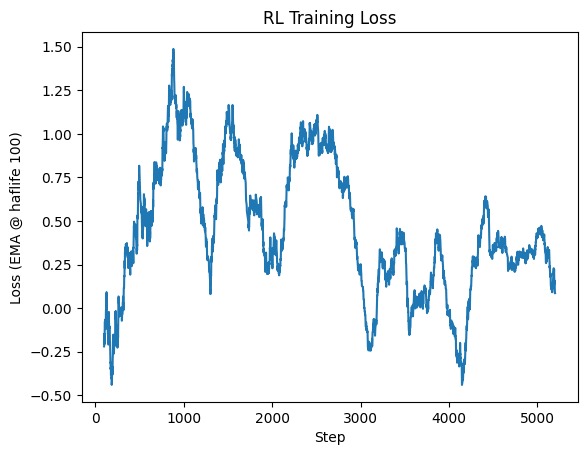

In [ ]:
pd.Series(all_losses).ewm(halflife=100, min_periods=100).mean().plot()
plt.xlabel("Step")
plt.ylabel("Loss (EMA @ haflife 100)")
plt.title("RL Training Loss")
plt.show()

## 3.3 Evaluate RL Policy

In [ ]:
## Run eval loop with fine-tuned model
rl_episodes = {"rl": []}
num_episodes_per_agent = 20

for ep in range(num_episodes_per_agent):
    printmd(f"#### Episode {ep}")
    memory, data, total_reward = episode_rollout(model_lora, gameFold="test",  seed=ep * 123)
    rl_episodes['rl'].append({"ep": ep, "total_reward": total_reward, "memory": memory, "data": data})

## save results
with open(f"{target_dir}/episodes_rl_agent.json", "w") as f:
    json.dump(rl_episodes, f)

## print an episode
printmd('\n\n'.join(rl_episodes['rl'][0]['memory']))

#### Episode 0

Episode Progress: 0it [00:00, ?it/s]

#### Episode 1

Episode Progress: 0it [00:00, ?it/s]

#### Episode 2

Episode Progress: 0it [00:00, ?it/s]

#### Episode 3

Episode Progress: 0it [00:00, ?it/s]

#### Episode 4

Episode Progress: 0it [00:00, ?it/s]

#### Episode 5

Episode Progress: 0it [00:00, ?it/s]

#### Episode 6

Episode Progress: 0it [00:00, ?it/s]

#### Episode 7

Episode Progress: 0it [00:00, ?it/s]

#### Episode 8

Episode Progress: 0it [00:00, ?it/s]

#### Episode 9

Episode Progress: 0it [00:00, ?it/s]

#### Episode 10

Episode Progress: 0it [00:00, ?it/s]

#### Episode 11

Episode Progress: 0it [00:00, ?it/s]

#### Episode 12

Episode Progress: 0it [00:00, ?it/s]

#### Episode 13

Episode Progress: 0it [00:00, ?it/s]

#### Episode 14

Episode Progress: 0it [00:00, ?it/s]

#### Episode 15

Episode Progress: 0it [00:00, ?it/s]

#### Episode 16

Episode Progress: 0it [00:00, ?it/s]

#### Episode 17

Episode Progress: 0it [00:00, ?it/s]

#### Episode 18

Episode Progress: 0it [00:00, ?it/s]

#### Episode 19

Episode Progress: 0it [00:00, ?it/s]

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. There is also a newspaper. You also see a dirty mesh skimmer. 
To the West you see the living room. 

###  `Action step 1`

`[Time]` 16:04:58

`[Valid Actions]`: ['open kitchen cupboard', 'take newspaper', 'take dirty mesh skimmer', 'open trash can', 'open fridge', 'open cutlery drawer', 'move west', 'inventory', 'open dishwasher', 'look around']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a can opener. There is also a milk. 
To the East you see the kitchen. To the West you see a closed wood door. 

###  `Action step 2`

`[Time]` 16:04:58

`[Valid Actions]`: ['look around', 'inventory', 'open door to west', 'move west', 'open wastepaper basket', 'close door to west', 'take can opener', 'take milk', 'move east']

`[Action]`: open door to west

`[Reward]`: 0.00

`[Obs]`: You open the wood door, revealing the bedroom. 

###  `Action step 3`

`[Time]` 16:04:58

`[Valid Actions]`: ['close door to west', 'open door to west', 'move east', 'take milk', 'move west', 'inventory', 'look around', 'take can opener', 'open wastepaper basket']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You are in the bedroom. In one part of the room you see a dressing table, that has nothing on it. There is also a desk chair, that has nothing on it. You also see a desk, that has nothing on it. In another part of the room you see a chest of drawers that is closed. In one part of the room you see a wardrobe that is closed. There is also a night stand, that has nothing on it. You also see a bed, that has nothing on it. 
Through an open wood door, to the East you see the living room. 

###  `Action step 4`

`[Time]` 16:04:59

`[Valid Actions]`: ['look around', 'inventory', 'open chest of drawers', 'close door to east', 'open wardrobe', 'open door to east', 'move east']

`[Action]`: close door to east

`[Reward]`: 0.00

`[Obs]`: You close the wood door to the living room. 

###  `Action step 5`

`[Time]` 16:04:59

`[Valid Actions]`: ['inventory', 'look around', 'open wardrobe', 'close door to east', 'move east', 'open chest of drawers', 'open door to east']

`[Action]`: close door to east

`[Reward]`: 0.00

`[Obs]`: That is already closed. 

###  `Action step 6`

`[Time]` 16:04:59

`[Valid Actions]`: ['move east', 'open chest of drawers', 'inventory', 'open door to east', 'open wardrobe', 'close door to east', 'look around']

`[Action]`: open chest of drawers

`[Reward]`: 0.00

`[Obs]`: You open the chest of drawers. It's empty inside.

###  `Action step 7`

`[Time]` 16:04:59

`[Valid Actions]`: ['open wardrobe', 'open door to east', 'close chest of drawers', 'move east', 'inventory', 'close door to east', 'look around']

`[Action]`: open wardrobe

`[Reward]`: 0.00

`[Obs]`: You open the wardrobe. It's empty inside.

###  `Action step 8`

`[Time]` 16:04:59

`[Valid Actions]`: ['open door to east', 'close chest of drawers', 'close wardrobe', 'close door to east', 'move east', 'inventory', 'look around']

`[Action]`: close wardrobe

`[Reward]`: 0.00

`[Obs]`: You close the wardrobe.

###  `Action step 9`

`[Time]` 16:05:00

`[Valid Actions]`: ['open wardrobe', 'close chest of drawers', 'inventory', 'look around', 'move east', 'close door to east', 'open door to east']

`[Action]`: close door to east

`[Reward]`: 0.00

`[Obs]`: That is already closed. 

###  `Action step 10`

`[Time]` 16:05:00

`[Valid Actions]`: ['open wardrobe', 'close door to east', 'look around', 'move east', 'open door to east', 'inventory', 'close chest of drawers']

`[Action]`: open wardrobe

`[Reward]`: 0.00

`[Obs]`: You open the wardrobe. It's empty inside.

###  `Action step 11`

`[Time]` 16:05:00

`[Valid Actions]`: ['move east', 'close wardrobe', 'inventory', 'look around', 'open door to east', 'close door to east', 'close chest of drawers']

`[Action]`: look around

`[Reward]`: 0.00

`[Obs]`: You are in the bedroom. In one part of the room you see a dressing table, that has nothing on it. There is also a desk chair, that has nothing on it. You also see a desk, that has nothing on it. In another part of the room you see an open chest of drawers, that is empty. In one part of the room you see an open wardrobe, that is empty. There is also a night stand, that has nothing on it. You also see a bed, that has nothing on it. 
To the East you see a closed wood door. 

###  `Action step 12`

`[Time]` 16:05:01

`[Valid Actions]`: ['close chest of drawers', 'close wardrobe', 'close door to east', 'inventory', 'look around', 'move east', 'open door to east']

`[Action]`: inventory

`[Reward]`: 0.00

`[Obs]`: Inventory: 
  Your inventory is currently empty.


###  `Action step 13`

`[Time]` 16:05:01

`[Valid Actions]`: ['look around', 'move east', 'close chest of drawers', 'close door to east', 'close wardrobe', 'inventory', 'open door to east']

`[Action]`: inventory

`[Reward]`: 0.00

`[Obs]`: Inventory: 
  Your inventory is currently empty.


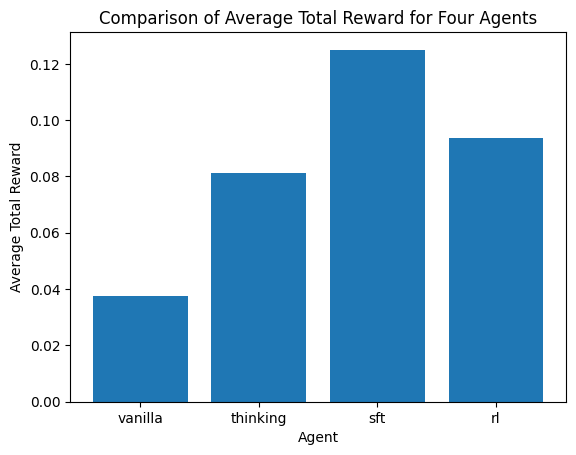

In [ ]:
all_eps = baseline_episodes | sft_episodes | rl_episodes

avg_rewards = {
    a: np.mean([ep["total_reward"] for ep in all_eps[a]])
    for a in ["vanilla", "thinking", "sft", "rl"]
}

# make a bar chart
agents = list(avg_rewards.keys())
rewards = list(avg_rewards.values())

plt.bar(agents, rewards)
plt.xlabel("Agent")
plt.ylabel("Average Total Reward")
plt.title("Comparison of Average Total Reward for Four Agents")
plt.show()

## 3.4 RL Results

* Do not be discouraged if RL did not beat SFT
expected to beat or the thinking baseline (sometimes itdoes, depends on the randomness)
* 🤔 **Training RL is notoriously hard and we did not implement many techniques of the RL literature!** 😭
* In fact, we implemented the most vanilla possible version of RL. One that is used only for toy examples.
* 🤩 And yet, **we only trained for a few minutes, we were able to improve over chain of thought agent at 5x the generation speed!** ⏩
* 🫵🏻 I challenge you to apply state-of-the-art RL to this problem! 🚅

# Conclusion: 🤗 What did we learn? 🤔

* 🌎 While prompting techniques are powerful, sometimes we need to ground our agent in a specific task by finetuning the neural network weights of the LLM.
* 🏰 LLMs are to big to be finetuned in the usual way. We need parameter efficient finetuning techniques such as LORA.
* 🧮 A little expert labeled data will go a long long way, even to finetune models with billions of parameters --> SFT
* 🐕 When no expert data is available, RL comes to the rescue!

<br>
<img src="https://drive.google.com/uc?export=view&id=1BCv4CkAcwl07yUBEmXcZANmUASPlyyYl" alt="drawing" width="600"/>
